### Plan

We are trying to confirm that we can identify detections of jovian moons in PS1 smf files.  

Here is our plan:

- Collect relevant smf files.

- Determine the mid-time of each smf file.

- Find the ephemerides for bright-ish jovian irregular moons for those times.


### The Detection Efficiency Plan

Imagine having a bunch of potential detections near a particular exposure, from actual stars and moving solar system bodies.  These are represented by RA, Dec, magnitude, colors, and maybe rate of motion.  The quantities are all physical, from a bunch of photons perhaps at the top of the atmosphere.  In reality these potential detections travel through the atmosphere and telescope optics and onto the focal plane.  Depending upon where they land, how bright source is, and other properties, this might result in a detection being written by the IPP into an smf file.

The idea is to simulate this process.  We generate a set of potential detections from a solar system model.  The model comprises a set of orbits and magnitudes (possibly variable).  We propagate those orbits to the times of each exposure.  If the resulting positions are plausibly within the field of view of the exposure, we look in more detail through the following steps:

1. We use the RA/Dec and the global WCS to determine which chip that potential detectin would land in.
2. Once we know the chip, we use the RA/Dec and the WCS of that chip to determine which x, y on the chip the detection corresponds to.
3. Then we use that x, y position to determine if the detection lands within the chip boundaries proceed to the next step.  If the detection is outside the chip boundary, i.e. in the gaps between chips or just outside the periphery of the mosaic of chips, the detection is lost.
4. We use the same chip-level x,y position to determine if the detection lands within or near enough to a cell.  If it doesn't (i.e. it is in the 'streets' between cells) the detection is lost.  If the detection lands within a cell, determine which cell and determine the pixel position within the cell.
5. Look up in the cell summary for that chip. If the cell is live, proceed to the next step.  Otherwise the detection is lost.
6. Probe the mask data for that detector, cell, and pixel position. If the mask values for that pixel, and possibly nearby pixels, indicate a problem, the detection is lost.  Otherwise, proceed.
7. Look up the detection efficiency curve for stationary sources for the chip in question. [Consider the idea of tracer particles to better same the detection efficiency as a function of magnitude, Jones and Juric].  [Matt P's point here about how being on live pixels is independent of magnitude is very helpful.]
8. Take the magnitude of the possible source from the model, in the exposure's filter, and add appropriate random noise.  This might be just shot noise, but it might include other sources of noise.  There is a lot of useful values, such as the sky noise, in the headers.  We might need to account for trailing at this point to.  
9. Compare this magnitude to the detection efficiency curve and draw a random number to determine if the detection occurs in the simulation.  If it does not, the detection is lost.  Otherwise, proceed.
10. At this point we need to generate a synthetic row for an smf file. We are not inserting rows into the orginal file, but into separate files.  The synthetic rows should have all the values as the actual detections in an smf.  Many have already be genereated in the proceeding steps, but others will need to be created.  For example, we will need the flags and the shape moments.  We can make placeholder values for anything that will not be used later, but if we are going to use it, we need to generate it.



In [18]:
import numpy as np
import pandas as pd
import scipy.interpolate as interpolate
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)
pd.set_option('display.notebook_repr_html', True)
import matplotlib
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
import math
import random
import itertools
from collections import defaultdict
import importlib
from astropy.io import fits

import ps1_astrom
import ps1_utils

from scipy.optimize import curve_fit
import scipy as sp

import ephem
import healpy as hp

import os
from scipy import spatial
import sqlite3 as lite
import sys
import warnings

from collections import Counter

import socket

import warnings
warnings.filterwarnings('ignore')

import MPC_library

from novas import compat as novas
from novas.compat import eph_manager
from novas.compat import solsys

# Make the figures bigger
plt.rcParams['figure.figsize'] = [12, 12]

first=lambda x: x[0]
second=lambda x: x[1]

from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body, get_moon

### The Pan-STARRS-1 Data

Rather than searching the Pan-STARRS-1 images themselves, we rely on catalogs of detections extracted from those images by the Image Processing Pipeline (IPP) [reference needed].  The image data comprises petabytes.  Fortunately, the catalogs extracted from those images comprise terabytes.

We have access to 1.3 million smf files. And more are being generated all the time (now on PS1 and PS2).

The Pan-STARRS catalog data from each exposure is stored in a multi-extension FITS files called an 'smf file', so named from its suffix.  I have no idea what 'smf' stands for or if 'file' is redundant, as in 'S M File file'.

There are 182 extensions in a standard smf.  These are:

+ PRIMARY for the overall exposure.  This includes the filter, the time and duration of the exposure, WCS information, and much, much more.  There is only header information for PRIMARY

+ MATCHED_REFS contains information about the referencd stars that were used to determine the astrometric solution and photometric zero point for the overall exposure as well as for each detector.  MATCHED_REFS has both header information and data.  The data is a binary table of the stars used.  It's incredibly useful!

+ For each of the 60 detectors/chips there is an '.hdr' extension, a '.psf' extension, and a '.deteff' extension. 

    - The '.hdr' extension contains header information for that detector.   This includes WCS information, and much much more.

    - The '.psf' extension is a binary table with each row representing a detection returned by the IPP.

    - The '.deteff' extension contains detection efficiency results based on synthetic sources inserted into the detector by the IPP.



Let's explore the structure and content of an smf file.  The fits package in astropy.io makes this very easy.

We can open any FITS file as below.  We get back an collection of HDU (Header-Data Units).

It takes about a second to open an smf file.  We can iterate over the HDUs in various pythonic ways.  (Refer to the astropy documentation for more details.)

Here's a link to a fast KD tree implementation:

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.cKDTree.html#scipy.spatial.cKDTree

Here is our first exposure:

o4992g0312o  PS1_V5  2454993.1140319  327.2157880  -11.5943840  y.00000  30.0

         2009-Jun-10 14:44:12.356 Am  329.76466    -12.99982  17.32   7.14 4.77087880211354 -24.7444612 327.4765672  -0.6432613

We know that Himalia is at this location at the time of the first smf file that we are interested in, as observed from F51.

 2009-Jun-10 14:44:12.356 Am  330.02989 -13.42029  15.00   8.25 4.62282447988126 -27.5012823 327.5743034  -1.1268735

At that same time, Jupiter is here:
 2009-Jun-10 14:44:12.356 Am  329.35727 -13.35592  -2.52   5.38 4.57849169493330 -25.1876315 326.9818424  -0.8417158
 2009-Jun-10 14:44:12.356 Am  329.76466 -12.99982  17.32   7.14 4.77087880211354 -24.7444612 327.4765672  -0.6432613

In [14]:
mu=0.001
rh = np.power(mu/3, 1/3)*206265/3600.
rh

3.9726712014981582

In [45]:
id df

,﻿,ID,smf-name,smf-filepath,reduction,JDUTC,RA,Dec,filter,exp-time,UVx,UVy,UVz,obseqx,obseqy,obseqz,obseclx,obseclsy,obseclz
0,1290,1290,o4992g0300o.76243.cm,./smf_downloads/3PI.2009-06-10/o4992g0300o.76...,PS1_V5,2.454993e+06,329.621607,-15.912170,y.00000,30.0,0.829648,-4.863313e-01,-2.741635e-01,-0.181276,-0.916558,-0.397326,-0.181276,-0.998972,4.663700e-05
1,1293,1293,o4992g0303o.76246.cm,./smf_downloads/3PI.2009-06-10/o4992g0303o.76...,PS1_V5,2.454993e+06,324.534744,-15.735953,y.00000,30.0,0.783943,-5.584640e-01,-2.712045e-01,-0.181241,-0.916563,-0.397328,-0.181241,-0.998979,4.647309e-05
2,1302,1302,o4992g0312o.76255.cm,./smf_downloads/3PI.2009-06-10/o4992g0312o.76...,PS1_V5,2.454993e+06,327.215788,-11.594384,y.00000,30.0,0.823561,-5.304277e-01,-2.009819e-01,-0.181134,-0.916580,-0.397336,-0.181134,-0.998997,4.596138e-05
3,1307,1307,o4992g0317o.76260.cm,./smf_downloads/3PI.2009-06-10/o4992g0317o.76...,PS1_V5,2.454993e+06,329.621239,-15.911818,y.00000,30.0,0.829647,-4.863375e-01,-2.741576e-01,-0.181077,-0.916589,-0.397340,-0.181077,-0.999007,4.568742e-05
4,1310,1310,o4992g0320o.76263.cm,./smf_downloads/3PI.2009-06-10/o4992g0320o.76...,PS1_V5,2.454993e+06,324.534596,-15.735931,y.00000,30.0,0.783941,-5.584660e-01,-2.712041e-01,-0.181040,-0.916595,-0.397343,-0.181040,-0.999014,4.550066e-05
5,1319,1319,o4992g0329o.76273.cm,./smf_downloads/3PI.2009-06-10/o4992g0329o.76...,PS1_V5,2.454993e+06,327.215873,-11.595200,y.00000,30.0,0.823559,-5.304249e-01,-2.009959e-01,-0.180932,-0.916612,-0.397351,-0.180932,-0.999033,4.495719e-05
6,2205,2205,o4998g0333o.78351.cm,./smf_downloads/3PI.2009-06-16/o4998g0333o.78...,PS1_V5,2.454999e+06,327.021263,-17.251509,y.00000,30.0,0.801134,-5.198396e-01,-2.965667e-01,-0.081224,-0.929123,-0.402775,-0.081224,-1.012668,4.489561e-05
7,2213,2213,o4998g0341o.78361.cm,./smf_downloads/3PI.2009-06-16/o4998g0341o.78...,PS1_V5,2.454999e+06,329.686524,-13.076262,y.00000,30.0,0.840892,-4.916429e-01,-2.262478e-01,-0.081130,-0.929129,-0.402778,-0.081130,-1.012675,4.449983e-05
8,2217,2217,o4998g0345o.78365.cm,./smf_downloads/3PI.2009-06-16/o4998g0345o.78...,PS1_V5,2.454999e+06,324.663442,-12.915262,y.00000,30.0,0.795131,-5.637463e-01,-2.235098e-01,-0.081083,-0.929132,-0.402780,-0.081083,-1.012679,4.429682e-05
9,2218,2218,o4998g0346o.78364.cm,./smf_downloads/3PI.2009-06-16/o4998g0346o.78...,PS1_V5,2.454999e+06,327.183816,-8.740471,y.00000,30.0,0.830654,-5.356519e-01,-1.519590e-01,-0.081072,-0.929133,-0.402780,-0.081072,-1.012679,4.424871e-05


In [55]:
df = pd.read_csv('smffilescorrect.csv')
df['JDUTC'], df['RA'], df['Dec']

results = {}
for id, jd_utc, ra, dec, in zip(df['ID'], df['JDUTC'], df['RA'], df['Dec']):
    ra_j, dec_j = get_planet('jupiter', jdObs)
    in_fov = near_fov(ra_j, dec_j, ra, dec, radius=0.7)
    results[id] = jd_utc, ra, dec, in_fov
    print(id, jd_utc, ra, dec, in_fov)

1290 2454993.105564195 329.621607 -15.912170000000001 [False]
1293 2454993.107650809 324.534744 -15.735953 [False]
1302 2454993.114031911 327.215788 -11.594384 [False]
1307 2454993.117372288 329.621239 -15.911817999999998 [False]
1310 2454993.119621745 324.534596 -15.735930999999999 [False]
1319 2454993.126050272 327.215873 -11.5952 [False]
2205 2454999.0720326803 327.021263 -17.251509 [False]
2213 2454999.077545891 329.686524 -13.076262 [ True]
2217 2454999.0803047405 324.663442 -12.915262 [False]
2218 2454999.08095205 327.18381600000004 -8.740471000000001 [False]
2224 2454999.0851179645 327.021254 -17.251427 [False]
2232 2454999.090590185 329.686448 -13.076365 [ True]
2236 2454999.0933403005 324.663351 -12.915503999999999 [False]
2237 2454999.093999136 327.18379300000004 -8.740687 [False]
3304 2455011.118434585 327.11967400000003 -14.42285 [False]
3306 2455011.1196204657 324.64745 -10.071185 [False]
3315 2455011.1255558054 329.74989700000003 -10.247781 [False]
3316 2455011.1261021867

In [56]:
results

{368642: (2456630.972967408, 107.43330300000001, 25.896992, array([False])),
 368643: (2456630.97365704, 106.589501, 23.223395, array([False])),
 368644: (2456630.974316681, 109.44868999999998, 23.631194, array([False])),
 368645: (2456630.974983429, 110.454305, 26.380501000000002, array([False])),
 638982: (2457437.9334429367, 170.94003700000002, 8.509995, array([False])),
 249857: (2456200.028402232, 73.783315, 17.507706, array([False])),
 638984: (2457437.934728224, 166.380019, 9.360004, array([False])),
 368649: (2456630.977628691, 113.43199399999999, 26.876092, array([False])),
 368650: (2456630.978286924, 112.33460500000001, 24.047795, array([False])),
 368651: (2456630.978945999, 115.219683, 24.5416, array([False])),
 249858: (2456200.0289031416, 71.24809599999999, 19.051202, array([False])),
 98318: (2455566.7308920342, 353.88532999999995, 2.739728, array([False])),
 98319: (2455566.731550159, 356.146307, 1.077181, array([False])),
 98320: (2455566.7322149384, 358.424139, -0.57

In [84]:
hdu_dict={}
with open('irregular_list.txt') as file:
    for line in file:
        filename = line.rstrip()
        key = filename.split('/')[1].split('.')[0]
        hdu_dict[key] = fits.open(filename)
        

In [68]:
hdu_dict['o5566g0114o']

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x1323538b00>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1328010748>, <astropy.io.fits.hdu.image.ImageHDU object at 0x132800a7b8>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1328050160>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1328056208>, <astropy.io.fits.hdu.image.ImageHDU object at 0x132807b588>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x13280983c8>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x132809e470>, <astropy.io.fits.hdu.image.ImageHDU object at 0x13280c3358>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x13280df198>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x13280e6240>, <astropy.io.fits.hdu.image.ImageHDU object at 0x132810aa90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1328125ef0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x132812cf98>, <astropy.io.fits.hdu.image.ImageHDU object at 0x13281546a0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1328

In [85]:
outfile = open('irregular_pointings.txt', 'w')
for fn in sorted(hdu_dict.keys()):
    hdus=hdu_dict[fn]
    fn_stem = fn.split('.')[0]
    phdr = hdus['PRIMARY'].header
    xhdr = hdus['XY33.hdr'].header
    psf_hdr = hdus['XY33.psf'].header
    try:
        #shutter_close = ps1_utils.date2JD(hdus['XY11.hdr'].header['SHUTCUTC'].replace(' ', 'T'))
        shutter_open = ps1_utils.date2JD(hdus['XY11.hdr'].header['SHUTOUTC'].replace(' ', 'T'))
        exptime = phdr['exptime']
        jdObs = shutter_open + 0.5*exptime/(24*3600.)
        filt = phdr['FILTERID']
        exttype = psf_hdr['EXTTYPE']

        ra  = phdr['RA']
        dec = phdr['Dec']
        ra_j, dec_j = get_planet('jupiter', jdObs)
        in_fov = near_fov(ra_j, dec_j, ra, dec, radius=0.5)
        print(in_fov)
            
        outstring = "%s  %s %16.7f %12.7f %12.7f  %s  %s %s\n" % (fn_stem, exttype, jdObs, float(ra), float(dec), filt, exptime, in_fov)
        outfile.write(outstring)
    except:
        pass

outfile.close()

[False]
[False]
[ True]
[ True]
[False]
[False]
[False]
[False]
[False]
[False]


Himalia at 
JD 2455566.7315502 358.0025135 -1.7795321
JD 2455566.7322149 358.0025897 -1.7794952
JD 2455566.7375823 358.0032055 -1.7791972

98338 2455566.7443842664 358.0039865 -1.7788195
  
JD 2455566.738244687 358.0032816 -1.7791604

In [24]:
# This is a tiny bit off.

def get_planet(planet, jd_utc):
    t = Time(jd_utc, format='jd', scale='utc')
    loc = EarthLocation.from_geocentric(0., 0., 0., unit='m')
    with solar_system_ephemeris.set('builtin'):
        jup = get_body('jupiter', t, loc) 
        ra, dec = jup.to_string(precision=8).split()
        ra, dec = float(ra), float(dec)
        return ra, dec

ra, dec = get_planet('jupiter', 2457871.861429352)
#194.87852  -4.66640 from F51
#194.87848  -4.66617 from 500

ra, dec

(194.88391255, -4.66949127)

In [77]:
hdu_dict['o5566g0105o']['XY11.psf'].data['RA_PSF']

array([354.93973537, 354.97784554, 354.84016764, ..., 355.13642645,
       355.02082132, 355.18941818])

In [1]:
hdu_dict['o5566g0124o']

NameError: name 'hdu_dict' is not defined

In [95]:
q_ra, q_dec = 358.0039865,  -1.7788195
min_ra = 400
max_ra = -10
for hdu in hdu_dict['o5566g0124o']:
    if '.psf' in hdu.name:
        for ra, dec, mag in zip(hdu.data['RA_PSF'], hdu.data['DEC_PSF'], hdu.data['CAL_PSF_MAG']):
            if ra>max_ra:
                max_ra = ra
                
            if ra<min_ra:
                min_ra = ra

            if np.abs(ra-q_ra) < 0.0001 and np.abs(dec-q_dec)< 0.0001:
                print(ra, q_ra, dec, q_dec, mag, (ra-q_ra)*3600, (dec-q_dec)*3600)
            
min_ra, max_ra            

358.0039227612205 358.0039865 -1.7788464270288955 -1.7788195 15.651759 -0.22945960615743388 -0.09693730402382528


(356.8511825287482, 359.9876020954527)

In [26]:
(ra-194.87848)*3600

19.557179999981145

In [8]:
for k, hdu in hdu_dict.items():
    print(k)

o4992g0312o
o4998g0341o
o4992g0329o
o4998g0360o


In [66]:
# It's handy to have a list of the names of the chips.

chips=['XY01', 'XY02', 'XY03', 'XY04', 'XY05', 'XY06',
       'XY10', 'XY11', 'XY12', 'XY13', 'XY14', 'XY15', 'XY16', 'XY17',
       'XY20', 'XY21', 'XY22', 'XY23', 'XY24', 'XY25', 'XY26', 'XY27',
       'XY30', 'XY31', 'XY32', 'XY33', 'XY34', 'XY35', 'XY36', 'XY37',
       'XY40', 'XY41', 'XY42', 'XY43', 'XY44', 'XY45', 'XY46', 'XY47',
       'XY50', 'XY51', 'XY52', 'XY53', 'XY54', 'XY55', 'XY56', 'XY57',
       'XY60', 'XY61', 'XY62', 'XY63', 'XY64', 'XY65', 'XY66', 'XY67',
       'XY71', 'XY72', 'XY73', 'XY74', 'XY75', 'XY76']

In [67]:
hdu_names = [hdu.name for hdu in hdus]
hdu_names[0:5]

['PRIMARY', 'MATCHED_REFS', 'XY01.hdr', 'XY01.psf', 'XY01.deteff']

We see all 182 extension names.  The PRIMARY header looks like this: 

A chip header looks like this:

Each image from each detector from each exposure gets a unique, sequential ID number.  This is very useful.

In [ ]:
[(hdu.name, hdu.header['IMAGEID']) for hdu in hdus if '.hdr' in hdu.name][0:10]

Each detector is the same size.

### Static Masks

The PS1 detectors are orthogonal transfer arrays (OTAs).  They can be read out very quickly, and individual cells can be accessed.  However, because these are prototype detectors, there are many defects.  There are also intra-cell streets and inter-detector gaps.  Fortunately, there are 'static masks' that record the characteristics of each pixel.  These are available to help make sense of the detectors.

- A static mask is itself a multi-extenion FITS file with 65 extensions. 
- The first is a PRIMARY extension with the details.
- The remaining 64 correspond to the 8x8 grid of cells within a detector, each of which is referred to by a name such as 'xy23'.  The lower case 'xy' means cell.  The upper case 'XY' means chip or detector.
- For each cell there is a 590 x 598 array of 16 bit integers.
- The integers themselves are bit masks that encode information about each cell.
- What each bit value means in the primary exentions header, as well as in the header of each cell file.  
- So, overall there are 60 detectors, each with 64 cells, each of which is a 590x598 array of 16-bit integers.   1.4 giga-pixels, with each pixel being a 16-bit integer.  That's a lot of data, but it can be held in memory.

- Explain the orientation of axes.  That's a huge pain!

Notice that naxis1=590 and naxis2=598, but the shape of the data is 598, 590.  This is a basic difference between numpy and the old FITS fortran world.


The static masks are rarely updated.  Mostly the detectors stay the same.  Short term changes and other effects are encoded in dynamic masking.

It's slow to load a full mask; we don't want to do that every time we need a value.  We need a data structure to maintain the mask data so that we can repeatedly and quickly look up values.

For that we will load each mask data into a dictionary.
- The keys are the detector names.  
- The value for each detector is another dictionary,  keyed on the cell names.  
- The values for each cell name are the numpy arrays that represent the static mask for that cell in that detector.  

Phew!

Let's load one.  Yes, it's pretty slow to do that, about 10-20 sec.

In [ ]:
%%time
maskdir = 'staticmask1072fits'

def load_mask(maskdir, chipnames):
    mask_data={}
    for chip in chipnames:
        detector = '*'+chip+'*'
        maskfile = list(ps1_astrom.locate(detector, maskdir))[0]
        mask = fits.open(maskfile)
        mask_data[chip] = mask
    return mask_data


mask = load_mask(maskdir, chips)


The name of the file used for the detrending mask is recorded in the header for each chip.  We need to make sure we have all of them.

In [ ]:
[hdu.header['DETREND.MASK'] for hdu in hdus if 'hdr' in hdu.name][0:10]

Now that we have the pixels masks loaded, we also need a translation between the bit values and what they correspond to.  Let's put the names (e.g. 'CTE', 'SPIKE', etc) and the values (16, 512, etc) into dictionaries for ease of use.  We want to be able to go in either direction, from a value to what it represents or from a mask name to its value.

In [ ]:
hdr = mask['XY33']['xy31'].header
mask_name_dict = {hdr[k]:hdr[k.replace('NAM', 'VAL')] for k in hdr if 'MSKNAM' in k}
mask_value_dict = {hdr[k.replace('NAM', 'VAL')]:hdr[k] for k in hdr if 'MSKNAM' in k}
mask_value_dict

In [ ]:
live_pixel_fraction={}
for chip, chip_hdus in mask.items():
    cnts   = np.sum([ps1_utils.cell_pixel_value_count(cell.data, 1)[0] for cell in chip_hdus if 'xy' in cell.name])
    totals = np.sum([ps1_utils.cell_pixel_value_count(cell.data, 1)[1] for cell in chip_hdus if 'xy' in cell.name])
    live_pixel_fraction[chip] = (totals-cnts)/totals

A live pixel count of the edge and interior regions would be more useful.

Some of the detectors are worse than others.  The Pan-STARRS folks placed the worst detectors in the corners and edges of the focal plane.  Here are the ten worst detectors.

In [ ]:
sorted([(k, v) for k, v in live_pixel_fraction.items()], key=second)[0:10]

In [ ]:
def plot_mask_data(chip, mask_hdus, vmin=0, vmax=10):
    f, axarr = plt.subplots(8, 8, sharex=True, sharey=True)
    for i in range(8):
        for j in range(8):
            cell_name = 'xy%d%d' % (j, i)
            image_data = mask_hdus[chip][cell_name].data
            axarr[i][j].imshow(image_data, vmin=vmin, vmax=vmax)
            axarr[i][j].set_title(cell_name)
            axarr[i][j].set_xlim(600, 0)

#### Dead Cells

In addition to what's indicated in the static mask, sometimes cells drop out temporarily.  If that happens, it is helpfully indicated in the headers.  I wrote a function called get_cell_summaries that grabs the summary about cells from headers of each chip in the set of HDUs, putting it all in a dictionary.  If the result is 'S', the chip is active generating science.  'D' means the cell is dead.  'V' means the cell is being used in video mode.  There might be other values, but I haven't seen them yet.

In [ ]:
cell_summary_dict = ps1_utils.get_cell_summaries(hdus)

### Matched Reference Stars

The IPP provides a table of all the reference stars used for fitting the astrometric and photometric solution for the exposure.  Again, this is incredibly useful!

In [ ]:
mrefs = hdus['MATCHED_REFS']

zpt_obs = hdus['XY01.hdr'].header['ZPT_OBS']
exptime = hdus['XY01.hdr'].header['EXPTIME']

mag_obs = mrefs.data['MAG_INST'] + zpt_obs + 2.5*np.log10(exptime)
mag_ref = mrefs.data['MAG_REF']

In [ ]:
mrefs.columns

In [ ]:
plt.scatter(mag_ref, mag_obs, s=1)

In [ ]:
_ = plt.hist(mag_obs-mag_ref, bins=1000)
plt.xlim(-0.5, 0.5)
(mag_obs-mag_ref).mean(), (mag_obs-mag_ref).std()

The astrometry in 'MATCHED_REFS' is also very good.  Here are histograms of the residuals of the fitted x, y pixel positions.

In [ ]:
_ = plt.hist(mrefs.data['X_CHIP']-mrefs.data['X_CHIP_FIT'], bins=50, range=(-1,1), alpha=0.5)
_ = plt.hist(mrefs.data['Y_CHIP']-mrefs.data['Y_CHIP_FIT'], bins=50, range=(-1,1), alpha=0.5)


### Astrometry

As noted earlier, the smf files contain the WCS solutions for the chips and overall mosaic.  These have been fit using the stars in the MATCHED_REFS extension.

There are actually many WCS solutions in an smf file.  There is one in the 'PRIMARY' extension that is for the overall mosaic.  Then there is a solution for each detector.

Fortunately, Eddie Schlafly has done the hard work of determining how to extract the various WCS parameters and how to use those parameters to determine an RA,Dec position given an x,y value in a detector or for the overall mosaic, and vice versa. 

In [ ]:
%%time
smfcoord = ps1_astrom.readsmfcoords(smf)

 I made a version that uses an already opened fits file.  This is indeed faster.  We should keep this in mind when we are processing 1.3 million smf files.

In [ ]:
%%time
smfcoord = ps1_astrom.readsmfcoords(smf, hdus)

The function readsmfcoords returns a dictionary with 61 key:values pairs, one for the 'PRIMARY' extensions and one for each of the 60 chips.

The 'PRIMARY' WCS converts to and from global focal plane pixel values.  The WCS solutions for each chip convert to and from chip-level pixel values to the focal plane-level pixel values.  These place and orient each chip in its spot in the overall mosaic.

### Detection Efficiency Information

The IPP provides extremely useful detection efficiency information that is recorded in the deteff extensions.  Five hundred synthetic, stationary point sources with the local PSF are injected into each chip.  This is done for a number of magnitude bins that are arranged around the instrumental magnitude of the expected 50% detection limit.  The IPP records how many of those injected sources are recovered in each bin as a function of magnitude.

The sources are first injected across each detector, and then the bad mask is applied.  Some of the detections are lost because they are too faint or land in vignetted regions of the focal plane.  Some are lost because they fall into the 'streets' between cells.  Some are masked out because the detector is poor there. 

Most solar system sources are not trailed in the PS1 exposures; they appear stationary within the time span of the exposure.  Given that, the point source detection efficiency information is all that is needed in most cases.  

For trailed sources, we could use detections of known fast-moving objects to calibrate an analytic model.

NOTE: We can also use known stationary source and known moving sources to check and calibrate our detection efficiency process.

I looked at this stats write up when thinking about how to calculate the probability of a 5-sigma detection of a function of magnitude:
https://www.roe.ac.uk/japwww/teaching/astrostats/astrostats2012_part2.pdf

In [ ]:
def deteff_functional(mag_ref, zpt_obs, exptime, gain, delta, b, max_frac, counts):
    #print(mag_ref, zpt_obs, exptime , b, max_frac, counts)
    def deteff_fn_offset_internal(offset):
        nsig=5.0
        mag = offset + delta + mag_ref + zpt_obs + 2.5*np.log10(exptime) - 2.5*np.log10(gain)
        signal = np.power(10.0, -0.4*(mag-zpt_obs))
        noise = np.sqrt(b + signal)
        snr = signal/noise
        X=(nsig*noise-signal)/noise
        max_frac=1
        f = 0.5*max_frac*counts*(1.0 - sp.special.erf(X/np.sqrt(2.0)))
        return f
    def deteff_fn_mag_internal(mag):
        nsig=5.0
        signal = np.power(10.0, -0.4*(mag-zpt_obs))
        noise = np.sqrt(b + signal)
        snr = signal/noise
        X=(nsig*noise-signal)/noise
        max_frac=1
        f = 0.5*max_frac*counts*(1.0 - sp.special.erf(X/np.sqrt(2.0)))
        return f
    return deteff_fn_offset_internal

xmodel = np.arange(-2,2,0.01)

def get_deteff_funcs(hdus):
    
    # Need the reference magnitude and exptime values in order
    # to get an acutal magnitude, in order to get a count rate,
    # in order to get a signal.
    #
    # We are just fitting for the offset from the assumed zero
    # point.
    # 
    # Likewise, we should be fitting for offsets from other 
    # reference values.
    #
    # We know the gain.  We have an estimate of the background
    # level.  We know the read noise.  And we know the number of
    # pixels used in the calculations.
    #
    
    def deteff_fit_func(offset, delta, b, max_frac):
        #print(delta, b, max_frac)
        nsig=5
        mag = offset + delta + mag_ref + zpt_obs + 2.5*np.log10(exptime) - 2.5*np.log10(gain)
        signal = np.power(10.0, -0.4*(mag-zpt_obs))
        noise = np.sqrt(b + signal)
        snr = signal/noise
        X=(nsig*noise-signal)/noise
        f = 0.5*max_frac*(1.0 - sp.special.erf(X/np.sqrt(2.0)))
        return f

    deteff_dict=defaultdict(dict)
    
    i=0
    
    exptime=None
    gain=None
    zpt_ref=None
    
    for hdu in hdus:
        if 'hdr' in hdu.name:
            hdr = hdu.name
            if 'EXPTIME' in hdus[hdr].header:
                exptime = hdus[hdr].header['EXPTIME']
            if 'ZPT_OBS' in hdus[hdr].header:
                zpt_obs = hdus[hdr].header['ZPT_OBS']
        if exptime and gain and zpt_obs:
            break
            
    ## We can use values from other chips for the guess.
    m0 = 0.0
    delta = 0.0
    max_frac=1.0
    b = 400.0

    for hdu in hdus:
        if 'deteff' in hdu.name:

            mag_ref = hdu.header['DETEFF.MAGREF']
            num = hdu.header['DETEFF.NUM']
            
            hdr = hdu.name.replace('.deteff', '.hdr')
            if 'GAIN' in hdus[hdr].header:
                gain = hdus[hdr].header['GAIN']
            else:
                gain = 1.0
        
            x = hdu.data['OFFSET'].astype(float)
            y = hdu.data['COUNTS']/num
            z = np.sqrt(hdu.data['COUNTS'])/num
            
            chip = hdu.name.rstrip('.deteff')
            hdr = chip+'.hdr'

            p0 = np.array([delta, b, max_frac])
            popt, _ = curve_fit(deteff_fit_func, x[1:-1], y[1:-1], sigma=z[1:-1], p0=p0)
            
            delta = popt[0]

            deteff_dict[chip]['func']=deteff_functional(mag_ref, zpt_obs, exptime, gain, *popt, 1.0)
            deteff_dict[chip]['params']=popt
            deteff_dict[chip]['magAdd']= mag_ref + delta + zpt_obs + 2.5*np.log10(exptime) - 2.5*np.log10(gain)

    return deteff_dict

def simulate_detection(chip, mag, deteff_funcs):
    f = deteff_funcs[chip]['func'](mag)
    sample=np.random.rand()
    return sample<f

In [ ]:
%%time
deteff_funcs = get_deteff_funcs(hdus)

We can also explore using an arctangent function to model the detection efficiency.  This is appropriate is we think the counts in the noise follows a Cauchy distribution, rather than a gaussian or poisson distribution.

In [ ]:
    def arctan_fit_func(offset, delta, b, gamma, max_frac):
        mag = offset + delta + mag_ref + zpt_obs + 2.5*np.log10(exptime)
        signal = np.power(10.0, -0.4*(mag-zpt_obs))
        noise = np.sqrt(b + signal)
        snr = signal/noise
        nsig=5
        X=(nsig*noise-signal)/noise        
        f = max_frac*(0.5 + (1.0/np.pi)*np.arctan(X/gamma))
        return f



In [ ]:
def root_func(x, chip, deteff_funcs=deteff_funcs):
    delta, b, max_frac = deteff_funcs[chip]['params']
    return deteff_funcs[chip]['func'](x) - 0.5



We can try to understand the detection efficiency curves.  

Notice that even at bright magnitudes (on the left) not all sources are detected.  That's due to a fraction of them falling into the intra-chip gaps and onto chip defects.   We can estimate that fraction by counting the masked pixels in the detector.

Also, the 50% detection threshold varies from chip to chip.  Some detectors have better quantum efficiency than others.  Similarly, some detectors are noisier than others.  Both of these characteristics affect the overall detection efficiency of a detector.

The relative efficiencies and limiting magnitudes of the chips are pretty stable.  Further, there are many exposures throughout any night.  Exposures that are close in space and time probably have similar detection efficiencies.  This is all to say there is a lot of prior information about what the results should be.

DETEFF.MAGREF refers to an instrumental magnitude.  To use that, we take the simulated apparent magnitude, subtract the zero point and 2.5*log(exptime) and add 2.5*log(gain) to get an instrumental magnitude. 

We then compare the instrumental magnitude to the detection efficiency curve.  


In [ ]:


zpt_obs = hdus['primary'].header['zpt_obs']
exptime = hdus['primary'].header['exptime']
maglim = {}
mag_dict={}

xmodel = np.arange(-2, 2, 0.01)

for i, chip in enumerate(chips):
    chp=chip+'.hdr'
    nx = hdus[chp].header['NAXIS1']
    ny = hdus[chp].header['NAXIS2']
    sum=0
    for hdu in mask[chip]:
        if 'xy' in hdu.name:
            sum += np.sum(hdu.data<1)
    guess = sum/(nx*ny)
    mx = 500*deteff_funcs[chip]['func'](-20)

    eff = hdus[chip+'.deteff']
    hdr = hdus[chip+'.hdr']
    psf = hdus[chip+'.psf']
    mag_dict[chip] = psf.data['CAL_PSF_MAG']

    mm = eff.data['COUNTS'][0]
    num = eff.header['DETEFF.NUM'] 
    mag_ref = eff.header['DETEFF.MAGREF']
    gain = hdr.header['gain']

    answer = sp.optimize.brentq(root_func, -3, 3, args=(chip))
    popvt = deteff_funcs[chip]['params']
    delta, b, max_frac = deteff_funcs[chip]['params']
    print("%s  " % (chip), "%8.2f  %8.2f  %8.2f " % tuple(popvt), "%8.2f" % (guess), end='')
    print('     %6.3f   %6.3f' %(mag_ref, answer + 2.5*np.log10(exptime) + zpt_obs + mag_ref - 2.5*np.log10(gain)))
    
    maglim[chip] = answer + 2.5*np.log10(exptime) + zpt_obs + mag_ref - 2.5*np.log10(gain)

    offset = eff.data['offset']
    counts = eff.data['counts']        

    if chip in chips[55:60]:
        plt.plot(xmodel, max_frac*num*deteff_funcs[chip]['func'](xmodel))
        plt.scatter(offset, counts, label=chip)


In [ ]:
for chip in chips[14:15]:
    print(chip)
    _=plt.hist(ps1_utils.non_nan(mag_dict[chip]), bins=50, range=(18,24), alpha=0.3)
    plt.vlines(maglim[chip], 0, 250)

### False Detections and Bayesian Stuff

The number of detections from a particular chip, or even cell, should be a function of the number of live pixels in it.  Dead pixels don't report photons.  Amazingly, there might be approaching 10^12 detections in the Pan-STARRS survey.  That estimate comes the product of 1.3x10^6 exposures and 1.5x10^5 detections/exposure.  The camera has 1.4x10^9 pixels.  That means that on average each pixel has been at the center of about 700 detections, some real and some false.

If we make the assumption that detections that correspond to sources in the stationary catalog are real and that all other detections are false, which is not a bad assumption, we can estimate a prior probability that a detection is real or false.

$$  P(A|B) = \frac{P(B|A) P(A)}{P(B)}  $$



Some pixels will contribute much more than the average number of detections.  But the number and distribution of real sources, other than moving solar system objects, is not changing.  Those locations are essentially fixed.    So we can keep track of which detector, cell, and pixel location each detection is centered on.  

Our real-bogus classifier will use all the information in the smf, both from the chip and row in which the detection is reported and the other information in the smf, as well as the prior information that comes from the accumulation of many exposures, to estimate the probability that a particular detection is real or bogus.  

The clasifier could use information about sky brightness, time of day, stellar crowding in the region, etc, in its estimates.


- true positive: a detection corresponding to a real source is reported at a given pixel location, and it is classified as real.
- true negative: a detection for which there is no physical source is reported at a given pixel location, and it is classified as false.
- false positive: a detection for which there is no physical source is reported at a given pixel location, and it is classified as real.
- false negative: a detection corresponding to a real source is reported at a given pixel location, and it is classified as false.

We can estimate some of these probabilities because we have an extensive catalog of known sources.  In many cases we will know of a source that is predicted to be seen at a given pixel location.  We will have a prior estimate of its magnitude in various filters, which we can use to estimate the likelihood of detecting it.  Because there are so many exposures, most astrophysical objects that can be detected by Pan-STARRS will have been detected at some point.  Of course, there are some variable sources that might be only rarely detected and there are moving objects, the focus of this project, but these are a small fraction of the total.  We can use the known stationary and moving sources to estimate the true positive rate and false negative rate.

We also have an abundance of false detections.  Some occur in particular detector regions.  Some are due to sky fluctations or scatter light.  Regardless, if a detection does not correspond to an object in the catalog, most likely it is false.  There are some detector regions with many more false detections.  Detections in those regions are more likely to be false.   We can use this information to estimate the true negative and false positve rates.

A few versions of the IPP software have been used; the version used is noted in the smf headers. The static masks are updated from time to time.  And the telescope, camera, and detectors have gone through various changes.  All of these can affect the detection efficiencies and false positive rates.  Fortunately, there is enough data to track these changes and their effects.

Let's start by exploring the data.

We can extract all the chip-level x,y positions for all the detectors into a couple of lists, for plotting.

In [ ]:
# Need to defend against missing extensions.
x, y = [],[]
for chip in chips:
    x += list(hdus[chip+'.psf'].data['X_PSF'])
    y += list(hdus[chip+'.psf'].data['Y_PSF'])


If we folded the x,y values on the scales of the separations of cells, we see the edges have an abundance of detections. (A plot is shown below, with horizontal and vertical lines to guide the eye.)  I believe Charles Chen first showed me a version of this. 

Most of the excess detections along the edges of the cells must be false; nature isn't playing astrophysical tricks on us.

In [ ]:
plt.scatter(ps1_utils.foldx(x), ps1_utils.foldy(y), s=1)
plt.xlim(-5,595)
plt.ylim(-5,603)
plt.hlines((7, 587), 0,600)
plt.vlines((12, 581), 0,600)

The fraction of pixels on the edge of a cell is a few percent, but the number of false detections there is very high.
We can extract various sets of detections to get a sense of how many false detections there are in the edges.  

In [ ]:
#plt.hlines((7, 587), 0,600)
#plt.vlines((12, 581), 0,600)
middle_xs = [x for x,y in zip(x, y) if ps1_utils.foldy(y)>7 and ps1_utils.foldy(y)<587]
middle_ys = [y for x,y in zip(x, y) if ps1_utils.foldx(x)>12 and ps1_utils.foldy(x)<581]

middle_xys = [(x,y) for (x,y) in zip(x, y) if ps1_utils.foldx(x)>12 and ps1_utils.foldx(x)<581 and ps1_utils.foldy(y)>7 and ps1_utils.foldy(y)<587]
middle_xys = np.array(middle_xys)

In [ ]:
plt.scatter(ps1_utils.foldx(middle_xys[:,0]), ps1_utils.foldy(middle_xys[:,1]), s=1)

In [ ]:
inside= ps1_utils.interior(ps1_utils.foldx(x), ps1_utils.foldy(y))
xf=ps1_utils.foldx(x)
yf=ps1_utils.foldy(y)

plt.scatter(xf[~inside], yf[~inside], s=1)

In [ ]:
foo = plt.hist(ps1_utils.foldx(middle_xs), bins=600)
plt.vlines((12, 581), 0,600)
plt.ylim(-10,2200)

In [ ]:
foo = plt.hist(ps1_utils.foldy(middle_ys), bins=600)
plt.vlines((12, 587), 0,2200)
plt.ylim(-10,2200)

### Detection Flags

As the IPP is run on Pan-STARRS images and sources are extracted, a large number of characteristics are recorded along the basic properties of each detection (Magnier et al. 2016).  Many of these are binary (yes/no) conditions that are encoded in bitmasks.  These are useful because they constitute potential features in a real-bogus analysis (references).

From Magnier et al (2016), I have extracted two tables that describe meaning of each in the FLAGS and FLAGS2 valaus

https://arxiv.org/pdf/1612.05244



In [ ]:
flags_dict = {}
with open('FLAGS.txt') as file:
    for line in file:
        line = line.rstrip()
        if line.startswith('#'):
            continue
        else:
            name    = line[0:20].strip()
            flag    = int(line[20:30], 0)
            comment = line[32:-1]
            flags_dict[flag] = (name, comment)
            
flags2_dict = {}
with open('FLAGS2.txt') as file:
    for line in file:
        line = line.rstrip()
        if line.startswith('#'):
            continue
        else:
            name    = line[0:22].strip()
            flag    = int(line[22:33], 0)
            comment = line[34:-1]
            flags2_dict[flag] = (name, comment)
flags_dict

In [ ]:
# Don't want any of these to be set.
bad_flags = 8 + 16 + 128 + 2048 + 4096 + 8192 + 32768 + 65536 + 131072 + 262144 + 268435456 + 536870912 + 1073741824 + 2147483648
for k,v in flags_dict.items():
    if k & bad_flags != 0:
        print(v)
        
hex(bad_flags)

### Putting some pieces together

Now that we have a lot of the pieces, we can start putting them together.  Here's a simple synthetic population to work with.  It's a set of positions uniformly sampled in a circular region centered on the exposure but with a radius somewhat larger than the field of view of the camera.

In [ ]:
ra_center = hdus['PRIMARY'].header['RA']
dec_center = hdus['PRIMARY'].header['DEC']
radius = 2.2
nsamples=1000000
mag_min = 20.
mag_max = 24.

ras = ra_center + np.cos(dec_center*np.pi/180.)*radius*(2.0*np.random.rand(nsamples)-1.)
decs = dec_center + radius*(2.0*np.random.rand(nsamples)-1.0)
mags = mag_min + (mag_max-mag_min)*np.random.rand(nsamples)

#inst_mags = mags - zpt_obs - 2.5*np.log10(exptime) + 2.5*np.log(gain)


In [31]:
def near_fov(ra, dec, ra_c, dec_c, radius=1.7):
    xc = np.cos(ra_c*np.pi/180.)*np.cos(dec_c*np.pi/180)
    yc = np.sin(ra_c*np.pi/180.)*np.cos(dec_c*np.pi/180)
    zc = np.sin(dec_c*np.pi/180)
    x = np.cos(ra*np.pi/180.)*np.cos(dec*np.pi/180)
    y = np.sin(ra*np.pi/180.)*np.cos(dec*np.pi/180)
    z = np.sin(dec*np.pi/180)
    # there must be a better way than the line below
    angles = np.arccos(np.dot(np.vstack((x, y, z)).T, np.vstack((xc, yc, zc))))*180.0/np.pi
    angles = angles[:,0]
    return (angles<radius)

In [ ]:
near = near_fov(ras, decs, ra_center, dec_center, radius=1.7)
ras = ras[near]
decs = decs[near]
mags = mags[near]
#inst_mags = inst_mags[near]

plt.scatter(ras, decs, s=1)

Next, we figure out which chips the potential detections are in.  For that we need the global focal plane x, y values of the potential detections.

In [ ]:
importlib.reload(ps1_astrom)
importlib.reload(ps1_utils)


In [ ]:
# 1. Calculate xy positions (local and global), as well as chips, from the RA,Dec values
# 2. Determine if the RA,Dec values are inside of a chip, inside of a live cell, and on live silicon within that cell.

# Outcomes:
# 0 = totally fine
# 1 = not inside chip
# 2 = cell dead
# 4 = not inside cell
# 8 = bad mask value
#
# Probably want an 'inside_circle' category, with an associated radius.
def throw_darts(r, d, m, smfcoord):
    _, local_xy_dict = ps1_astrom.rd_to_xy_chips(r, d, smfcoord)
    results_dict={}
    ii=0
    for k, v in local_xy_dict.items():
        print(k)
        idx, xp, yp = v
        if k != 'Corner':
            xpx = ps1_utils.foldx(xp).astype(int)
            ypx = ps1_utils.foldy(yp).astype(int)              
            cn = ps1_utils.get_cell_name(xp, yp)
            on_chip = ps1_utils.inside_chip(xp, yp)
            cell_ok = ps1_utils.cell_good(k, cn, cell_summary_dict)
            mask_ok = ps1_utils.mask_good(k, cn, xpx, ypx, mask)
            outcome = np.zeros(len(idx)).astype(int)
            outcome += (~on_chip)*1                
            outcome += (~cell_ok)*2    
            outcome += (~mask_ok)*4    
            # Separate categories
            outcome[outcome==3]=1
            outcome[outcome==5]=1
            outcome[outcome==7]=1
            results_dict[k] = idx, xp, yp, outcome, r[idx], d[idx], m[idx]
            nidx = idx[outcome==0]
            plt.scatter(ras[nidx], decs[nidx], s=1)
        else:
            outcome = np.ones(len(idx)).astype(int)
            results_dict[k] = idx, xp, yp, outcome, r[idx], d[idx], m[idx]
        ii+=1
    return results_dict

In [ ]:
# 1. Calculate xy positions (local and global), as well as chips, from the RA,Dec values
# 2. Determine if the RA,Dec values are inside of a chip, inside of a live cell, and on live silicon within that cell.

# Outcomes:
# 0 = totally fine
# 1 = not inside chip
# 2 = cell dead
# 4 = not inside cell
# 8 = bad mask value
#
# Probably want an 'inside_circle' category, with an associated radius.
def throw_darts_v2(r, d, m, smfcoord):
    _, local_xy_dict = ps1_astrom.rd_to_xy_chips(r, d, smfcoord)
    results_dict={}
    cell_dict=defaultdict(defaultdict)
    ii=0
    for k, v in local_xy_dict.items():
        print(k)
        idx, xp, yp = v
        if k != 'Corner':
            cn = ps1_utils.get_cell_name(xp, yp)
            idx_list=[]
            cdict=defaultdict(list)
            for c, id in zip(cn, idx):
                cdict[c].append(id)
            cell_dict[k] = cdict
            return cell_dict, cdict

            results_dict[k] = idx, xp, yp, outcome, r[idx], d[idx], m[idx]
            nidx = idx[outcome==0]
            plt.scatter(ras[nidx], decs[nidx], s=1)
        else:
            outcome = np.ones(len(idx)).astype(int)
            results_dict[k] = idx, xp, yp, outcome, r[idx], d[idx], m[idx]
        ii+=1
    return results_dict

In [ ]:
res_dict = throw_darts(ras, decs, mags, smfcoord)

In [ ]:
print('---------------------------------------')
print('outcomes:')
print('0 = totally fine')
print('1 = not inside chip')
print('2 = cell dead')
print('4 = bad mask value')
print('---------------------------------------------------')
print('   Chip           0       1       2       4       6')
print('---------------------------------------------------')
for chip in chips + ['Corner']:
    print("%7s" %(chip), '    ', end=' ')
    for i in [0,1,2,4,6]:
        print("%6d " %(np.sum(res_dict[chip][3]==i)), end=' ')
    print()

Next, we make use of the detection efficiency curves.  For that we need to associate an apparent magnitude with each of the synthetic potential detections, compared to the expected 50% detection threshold.

In [ ]:
zpt_obs = hdus['PRIMARY'].header['ZPT_OBS']
exptime = hdus['PRIMARY'].header['EXPTIME']
for chip in chips:
    idx,_,_,outcome,_,_,_= res_dict[chip]
    num = hdus[chip+'.deteff'].header['deteff.NUM']
    mag_ref = hdus[chip+'.deteff'].header['deteff.MAGREF']
    delta, b, max_frac = deteff_funcs[chip]['params']
    answer = sp.optimize.brentq(root_func, -3, 3, args=(chip))
    mag_lim = answer + mag_ref + zpt_obs + 2.5*np.log10(exptime) - 2.5*np.log10(gain)

    print(chip, '%6.3f %6.3f' % (mag_lim, answer), len(idx), len(idx[outcome==0]))
    detected = simulate_detection(chip, mags[idx]-mag_lim, deteff_funcs)
    nout = outcome + (~detected)*8
    nidx = idx[nout==0]
    plt.scatter(ras[nidx], decs[nidx], s=1)
#plt.xlim(206.5, 203.0)
#plt.xlim(212.5, 209)

The next thing to work on is generating synthetic smf rows.  The detection efficiency curves need a little work (a Cauchy distribution/cumulative arctan, might be better in some cases).  We might need to think about trailing too. 

Instead of inserting entire synthetic rows, I might create an additional extension for each detection.  The additional extensions would contain the synthetic rows.  Basically, any 'darts' that land on live pixels and don't bounce off the target are recorded.

For each 'dart' that is registered as a detection, first record an ID, RA/Dec, x/y, and possibly moments.  In a subsequent step we can generate a magnitude and uncertainties (which depend upon S/N).

RA_PSF, DEC_PSF, X_PSF, Y_PSF, rates of motion, ID


### 3PI Stack Images

The PS1 image layout for the 3PI survey is called the RINGS.V3 tessellation (Magnier/Budavari reference).   
https://arxiv.org/abs/1612.05244

The sky is divided into enumerate regions that are ~4 deg x 4 deg.  These are referred to as 'sky chips'.  Each sky chip is subdivided into a 10 x 10 grid, enumerated 0-99.  Each of these subdivisions is referred to as a 'sky cell'.

The numbers that characterize the Magnier-Budavari grid are available in a FITS table.

In [ ]:
grid = fits.open('ps1grid.fits')
grid[1].columns

In [ ]:
for row in grid[1].data:
    print("%2d %6.1f %9.3f %9.3f %04d %04d" % \
          (row['zone'], row['dec'], row['dec_min'], row['dec_max'], row['PROJCELL'], row['NBAND']))

Below we develop a function that takes an RA/Dec pair and a search radius and then returns a list of all the sky cells within that radius.  There is a degree of overlap between adjacent sky cells that needs to be taken into account, because there are some RA/Dec points that are covered by more than one sky cell.

In [ ]:
zone_dict = ps1_utils.make_zone_dict(grid)
hb_dict = ps1_utils.healpix_budavari_dict(zone_dict=zone_dict)

### Exploring the CMF Stacked Catalogs

Again, Eddie Schlafly saves the day by storing the cmf files of the PS1_V3 stacked catalogs.  These are unbelievably useful!  We can use them for the stationary catalog, except for the southern-most regions.

Here's the plan.  Separate for each filter:

- Select sources that are well above the detection limit, say SNR>7.

- Exclude any sources that have bad flags or nans in any of the quantities used for calculation or that will be output.

- Select the best fit from the PSF and extended source models.

- Output a small set of parameters to support a lightweight stationary source catalog.  This will probably be RA, Dec, mag, SNR, and model.


The 3pi stacks are represented in cmf files.  There are five cmf files (g, r, i, z, y) for each sky cell.  

Each cmf file has five extensions.  

- 'SkyChip.hdr' has header information about the overall region: WCS, zero point, etc.

- 'SkyChip.psf' has information regarding the results of PSF fitting for the sources.  This includes: RA_PSF, DEC_PSF, AP_MAG, CAL_PSF_MAG, etc. It includes all the sources.

- 'SkyChip.xfit' has information about the fits for extended sources.  For each source there are three entries, each for a different type of extended source model (exponential, DeVaucoulers, and Sersic).  Included fields are  RA_EXT, DEC_EXT, AP_MAG, PSF_INST_MAG, EXT_INST_MAG

- 'SkyChip.xrad' has IPP_IDET and contains the aperture flux measurements for the extended source fits.

- 'SkyChip.xsrc' has IPP_IDET and contains other extended fit measurements for the extended source fits.

- 'SkyChip.deteff' has detection efficiency information. I believe that this is for the point sources.

Many of the sources have been fit with a psf model, a pair of psfs, and up to three extended source models.  We need to figure out which of these is the best one to keep.  

Fortunately, the IPP_IDET field is a unique ID for the detection.  We can use that to track sources.



In [ ]:
cmf = fits.open('./cmf/1284/RINGS.V3.skycell.1284.000.stk.3507635.skycal.4317624.cmf')
input_files = [cmf['SkyChip.hdr'].header[h] for h in cmf['SkyChip.hdr'].header if 'INP_' in h]
sorted(list(map(lambda x: x.split('.wrp')[0], input_files)))[0:15]

In [ ]:
[c.name for c in cmf]

In [ ]:
cmf['SkyChip.hdr'].header

In [ ]:
for item in ps1_utils.get_budavari_centers(209, -7, 5, hb_dict):
    file_string = "*RINGS.V3.skycell.%04d.*" %(item)
    print('%4d' %(item), file_string, len(list(ps1_astrom.locate(file_string))))

In [ ]:
cell_dict=defaultdict(dict)
for item in ps1_utils.get_budavari_centers(209, -7, 5, hb_dict):
    print(item)
    for i in range(100):
        
        file_string = "*RINGS.V3.skycell.%04d.%03d.*" %(item, i)
        for fname in ps1_astrom.locate(file_string):
            location = (item, i)
            hdus = fits.open(fname)
            filt = hdus['PRIMARY'].header['FPA.FILTERID']
            cell_dict[filt] = hdus
            print(location, filt, len(hdus['SkyChip.psf'].data), \
                  np.sum(np.isnan(hdus['SkyChip.psf'].data['CAL_PSF_MAG'])), len(hdus['SkyChip.xfit'].data))
            hdus.close()
        print()
        break
    break


In [ ]:
def cnt_nan(x):
    return np.sum(np.isnan(x))

def cnt_inf(x):
    return np.sum(np.isinf(x))

def not_nan(x):
    return ~np.isnan(x)

def flags_ok(x, mask=0xf007b898):
    return x & mask == 0

def mag_ok(x, mag_limit=35):
    return x<mag_limit

def chi2_ok(chi2, ndof, limit=3):
    return (chi2/ndof<limit)

In [ ]:
import functools
def good_source(hdu, keys, funcs):
    '''
    logical_and.reduce applies an element-wise logical_and a list of 
    boolean arrays.
     - This works to accumulate repeated applications of logical and, e.g. ((((A&B)&C)&D)&E)...
    Here the iterator is doing something horrendously complicated !!!
     - iterator/list = [f(*tuple(map(lambda x: hdu[x], k))) for f, k in zip(funcs, keys)]
     - This is iterating (using zip) to extract pairs of functions & keys into f & k (each key is a list of arbitrary length)
     - The function, f, is then passed a set of arguments (expanded using *tuple), ...
       --- The generation of these arguments is from the map "map(lambda x: hdu[x], k)", where each of the keys, k, is being passed into the header, hdu
       --- 
     - An example of the function f would be 
     >>> chi2_ok(*tuple(map(lambda x: psf[x], ['PSF_CHISQ', 'PSF_NDOF'])))
    '''
    #return functools.reduce(lambda x, y: np.logical_and(x,y), [f(*tuple(map(lambda x: hdu[x], k))) for f, k in zip(funcs, keys)], start)
    return np.logical_and.reduce([f(*tuple(map(lambda x: hdu[x], k))) for f, k in zip(funcs, keys)])#, start)

In [ ]:
def extract_catalog(cmf, chi2_thresh):
    hdr=cmf['SkyChip.hdr']
    xfit=cmf['SkyChip.xfit'].data
    psf=cmf['SkyChip.psf'].data

    psf_keys  = [['PSF_CHISQ'], ['PSF_NDOF'], ['RA_PSF'], ['DEC_PSF'], ['CAL_PSF_MAG'], ['FLAGS'], ['CAL_PSF_MAG'], ['PSF_CHISQ', 'PSF_NDOF']]
    psf_funcs = [not_nan, not_nan, not_nan, not_nan, not_nan, flags_ok, mag_ok, chi2_ok]
    psf_good = good_source(psf, psf_keys, psf_funcs)#, np.ones(len(psf)))

    ext_keys = [['EXT_CHISQ'], ['EXT_NDOF'], ['RA_EXT'], ['DEC_EXT'], ['EXT_INST_MAG'], ['EXT_CHISQ', 'EXT_NDOF']]
    ext_funcs = [not_nan, not_nan, not_nan, not_nan, not_nan, chi2_ok]
    ext_good = good_source(xfit, ext_keys, ext_funcs)#, np.ones(len(xfit)))

    chi2_dof_dict=defaultdict(list)

    psf_chi2_dof=psf[psf_good]['PSF_CHISQ']/psf[psf_good]['PSF_NDOF']
    idets = psf[psf_good]['IPP_IDET'].astype(int)
    ra = psf[psf_good]['RA_PSF']
    dec = psf[psf_good]['DEC_PSF']
    mag = psf[psf_good]['CAL_PSF_MAG']
    for idet, v, r, d, m in zip(idets, psf_chi2_dof, ra, dec, mag):
        chi2_dof_dict[idet].append(('PS_MODEL_PSF', v, (r, d, m, 'PS_MODEL_PSF', idet)))

    '''
    ext_chi2_dof=xfit[ext_good]['EXT_CHISQ']/xfit[ext_good]['EXT_NDOF']
    idets = xfit[ext_good]['IPP_IDET'].astype(int)
    ra = xfit[ext_good]['RA_EXT']
    dec = xfit[ext_good]['DEC_EXT']
    zpt_obs = hdr.header['ZPT_OBS']
    exptime = hdr.header['EXPTIME']
    gain    = hdr.header['CELL.GAIN']
    mag = xfit[ext_good]['EXT_INST_MAG'] + 2.5*np.log10(exptime) - 2.5*np.log10(gain) + zpt_obs
    mts = xfit[ext_good]['MODEL_TYPE']
    for idet, v, mt, r, d, m  in zip(idets, ext_chi2_dof, mts, ra, dec, mag):
        chi2_dof_dict[idet].append((mt, v, (r, d, m, mt, idet)))
    '''

    chi2_dict={}
    for k, v in chi2_dof_dict.items():
        mn = min(v, key=second)
        chi2 = mn[1]
        if chi2<chi2_thresh:
            chi2_dict[k]= mn[2]

    return np.array(list(chi2_dict.values()))

In [ ]:
psf=cmf['SkyChip.psf'].data
psf_keys  = [['PSF_CHISQ'], ['PSF_NDOF'], ['RA_PSF'], ['DEC_PSF'], ['CAL_PSF_MAG'], ['FLAGS'], ['CAL_PSF_MAG'], ['PSF_CHISQ', 'PSF_NDOF']]
psf_funcs = [not_nan, not_nan, not_nan, not_nan, not_nan, flags_ok, mag_ok, chi2_ok]
np.logical_and.reduce([f(*tuple(map(lambda x: psf[x], k))) for f, k in zip(psf_funcs, psf_keys)])
#good_source(psf.data, psf_keys, psf_funcs, np.ones(len(psf)))
#psf_good = good_source(psf, psf_keys, psf_funcs, np.ones(len(psf)))


In [ ]:
sr = 0.1*(1.0 / 3600.) * np.pi / 180.
def get_singles(r, d, sc, sr=sr):
    pts=ps1_utils.convert_points(r, d)
    tree = spatial.cKDTree(pts)
    idx = tree.query_ball_point(pts, sr)
    firsts=[first(ids) for ids in idx]
    singles = np.array([i==item for i,item in enumerate(firsts)])
    return singles


In [ ]:
def write_catalog(SkyChip, catalogs, comments, prefix='stationary_catalog'):
    skycells=[(SkyChip, '%03d' %(x)) for x in range(100)]
    for filt in ['g', 'r', 'i', 'z', 'y']:
        flt = "%s.00000" % (filt)
        #np.append(data, np.ones((data.shape[0], 1)), 1)
        cats = [(i, catalogs[flt][skycell]) for i, skycell in enumerate(skycells)]
        rdmx = [np.append(cat, i*np.ones((cat.shape[0], 1), dtype=np.int16), 1) for i, cat in cats]
        rdm = np.concatenate(rdmx)
        ra   = rdm[:,0].astype(float)
        dec  = rdm[:,1].astype(float)        
        
        mag     = rdm[:,2].astype(float)
        mt      = rdm[:,3]
        idet    = rdm[:,4].astype(np.int32)
        skycell = rdm[:,5]
        skychip = ps1_utils.get_skychip(ra, dec, zone_dict)

        in_chip = skychip==int(SkyChip)
        single = get_singles(ra, dec, skycell, sr=sr)
        keep = np.logical_and(in_chip, single)
        
        hdr = fits.Header()
        hdr['SkyChip'] = SkyChip
        hdr['filterID'] = flt
        for comment in comments:
            hdr['COMMENT'] = comment
        primary_hdu = fits.PrimaryHDU(header=hdr)
        table_hdu = fits.BinTableHDU.from_columns(
               [fits.Column(name='RA', format='1D', array=ra[keep]),
                fits.Column(name='Dec', format='1D', array=dec[keep]),
                fits.Column(name='MAG', format='1E', array=mag[keep]),
                fits.Column(name='MODEL_TYPE', format='20A', array=mt[keep]),
                fits.Column(name='IPP_IDET', format='1J', array=idet[keep]),
                fits.Column(name='SkyCell', format='1I', array=skycell[keep])
               ])
        table_hdu.name = 'statcat'
        hdu_list = fits.HDUList([primary_hdu, table_hdu])
        filename=prefix+'_%s_%s.fits' % (SkyChip, filt)
        hdu_list.writeto(filename)



In [ ]:
catalogs['r.00000']['1283', '003']

In [ ]:
hdus=fits.open('stationary_catalogs/stationary_catalog_1283_r.fits')

In [ ]:
hdus['primary'].header

In [ ]:
filt='r'
for item in ps1_utils.get_budavari_centers(209, -7, 5, hb_dict):
    center = '%04d' % (item)
    filename='*stationary_catalog_%s_%s.fits' % (center, filt)
    for fname in ps1_astrom.locate(filename):
        print(fname)
        with fits.open(fname) as hdus:
            r = hdus['statcat'].data['RA']
            d = hdus['statcat'].data['Dec']
            plt.scatter(r, d, s=0.1)
        

In [ ]:
filt='r'
pts_list=[]
mts_list=[]
m_cut=26
for item in ps1_utils.get_budavari_centers(209, -7, 5, hb_dict):
    center = '%04d' % (item)
    filename='*stationary_catalog_%s_%s.fits' % (center, filt)
    for fname in ps1_astrom.locate(filename):
        print(fname)
        with fits.open(fname) as hdus:
            r = hdus['statcat'].data['RA']
            d = hdus['statcat'].data['Dec']
            m = hdus['statcat'].data['mag']
            mt = hdus['statcat'].data['model_type']
            r=r[m<m_cut]
            d=d[m<m_cut]
            pts=ps1_utils.convert_points(r, d)
            pts_list.append(pts)
            mts_list.append(mt[m<m_cut])

pts = np.concatenate(pts_list)
mts = np.concatenate(mts_list)
        
tree = spatial.cKDTree(pts)

In [ ]:
filt='r'
pts_list=[]
mts_list=[]
m_cut=26
for item in ps1_utils.get_budavari_centers(209, -7, 5, hb_dict):
    center = '%04d' % (item)
    filename='*psf_catalog_%s_%s.fits' % (center, filt)
    for fname in ps1_astrom.locate(filename):
        print(fname)
        with fits.open(fname) as hdus:
            r = hdus['statcat'].data['RA']
            d = hdus['statcat'].data['Dec']
            m = hdus['statcat'].data['mag']
            mt = hdus['statcat'].data['model_type']
            r=r[m<m_cut]
            d=d[m<m_cut]
            pts=ps1_utils.convert_points(r, d)
            pts_list.append(pts)
            mts_list.append(mt[m<m_cut])

pts = np.concatenate(pts_list)
mts = np.concatenate(mts_list)
        
tree = spatial.cKDTree(pts)

In [ ]:
len(mts), len(pts)

In [ ]:
hdus=fits.open('/Users/mholman/Dropbox/smf/stationary_catalogs/stationary_catalog_1283_r.fits')
stars = hdus['statcat'].data['model_type']=='PS_MODEL_PSF'

In [ ]:
hdus=fits.open('/Users/mholman/Dropbox/smf/psf_catalog_1283_r.fits')
stars = hdus['statcat'].data['model_type']=='PS_MODEL_PSF'

Now, load an smf file, convert its RA/Dec values to xyz points, and see how many match in the tree.

In [ ]:
%%time

smf='smf/o6798g0316o.740822.cm.968660.smf'
smf='smf/o6798g0298o.740804.cm.968643.smf'

def label_smf(smf, hdus=None, suffix='_label', tree=None, sr=(2.0 / 3600.) * np.pi / 180.):
    open=False
    if not hdus:
        hdus=fits.open(smf)
        opened=True
    new_hdus=[]
    qpts_list=[]
    for hdu in hdus:
        if '.psf' in hdu.name:
        
            cols=[]
            # Look for matches with stationary sources
            if tree:
                r=hdu.data['RA_PSF']
                d=hdu.data['DEC_PSF']
                qpts = ps1_utils.convert_points(r, d)
                idx = tree.query_ball_point(qpts, sr)
                mtch = np.array([len(v)!=0 for v in idx], dtype=np.int16)
                match = fits.Column(name='MATCH', format='1K', array=mtch)
                cols.append(match)
        
            # Mark detections that are on the edges
            x=hdu.data['X_PSF']
            y=hdu.data['Y_PSF']
            inside = ps1_utils.interior(ps1_utils.foldx(x), ps1_utils.foldy(y))
            edge = fits.Column(name='EDGE', format='1K', array=~inside)
        
            cols.append(edge)
            orig_cols = hdu.columns
            new_cols = fits.ColDefs(cols)
            new_hdu = fits.BinTableHDU.from_columns(orig_cols + new_cols)
            new_hdu.name=hdu.name
            new_hdus.append(new_hdu)
            
        elif '.hdr' in hdu.name:
            # Needed to fix this in order to be able to save the file.
            hdu.header['NAXIS']=2
            new_hdus.append(hdu)
            
        else:
            new_hdus.append(hdu)
    
    #if opened:
    #    hdus.close()

    hdu_list = fits.HDUList(new_hdus)
    filename=smf.replace('.smf', suffix+'.smf')
    hdu_list.writeto(filename)

    return hdu_list




In [ ]:
def label_smf_mp(smf, hdus=None, suffix='_label', tree=None, sr=(2.0 / 3600.) * np.pi / 180., mp_tree=None, mp_sr=(0.5 / 3600.) * np.pi / 180.):
    open=False
    if not hdus:
        hdus=fits.open(smf)
        opened=True
    new_hdus=[]
    qpts_list=[]
    for hdu in hdus:
        if '.psf' in hdu.name:
        
            cols=[]
            # Look for matches with stationary sources
            if tree:
                r=hdu.data['RA_PSF']
                d=hdu.data['DEC_PSF']
                qpts = ps1_utils.convert_points(r, d)
                idx = tree.query_ball_point(qpts, sr)
                mtch = np.array([len(v)!=0 for v in idx], dtype=np.int16)
                match = fits.Column(name='MATCH', format='1K', array=mtch)
                cols.append(match)
                
            # Look for matches with minor planets
            if mp_tree:
                r=hdu.data['RA_PSF']
                d=hdu.data['DEC_PSF']
                qpts = ps1_utils.convert_points(r, d)
                idx = mp_tree.query_ball_point(qpts, mp_sr)
                mp  = np.array([len(v)!=0 for v in idx], dtype=np.int16)
                mpx = fits.Column(name='MOVING', format='1K', array=mp)
                cols.append(mpx)
        
            # Mark detections that are on the edges
            x=hdu.data['X_PSF']
            y=hdu.data['Y_PSF']
            inside = ps1_utils.interior(ps1_utils.foldx(x), ps1_utils.foldy(y))
            edge = fits.Column(name='EDGE', format='1K', array=~inside)
        
            cols.append(edge)
            orig_cols = hdu.columns
            new_cols = fits.ColDefs(cols)
            new_hdu = fits.BinTableHDU.from_columns(orig_cols + new_cols)
            new_hdu.name=hdu.name
            new_hdus.append(new_hdu)
            
        elif '.hdr' in hdu.name:
            # Needed to fix this in order to be able to save the file.
            hdu.header['NAXIS']=2
            new_hdus.append(hdu)
            
        else:
            new_hdus.append(hdu)
    
    #if opened:
    #    hdus.close()

    hdu_list = fits.HDUList(new_hdus)
    filename=smf.replace('.smf', suffix+'.smf')
    hdu_list.writeto(filename)

    return hdu_list


In [ ]:
def insert_synthetics_smf(smf, synth_dict, hdus=None, suffix='_synth'):
    open=False
    if not hdus:
        hdus=fits.open(smf)
        opened=True
    new_hdus=[]
    for hdu in hdus:
        new_hdus.append(hdu)
        if 'PSF' in hdu.name:
            chip = hdu.name.replace('.PSF', '')
            ID, xp, yp, outcome, r, d, m = synth_dict[chip]
            table_hdu = fits.BinTableHDU.from_columns(
                [fits.Column(name='RA_PSF', format='1D', array=r[outcome==0]),
                fits.Column(name='DEC_PSF', format='1D', array=d[outcome==0]),
                fits.Column(name='CAL_PSF_MAG', format='1D', array=m[outcome==0]),
                fits.Column(name='CAL_PSF_MAG_SIG', format='1D', array=m[outcome==0]),
                fits.Column(name='X_PSF', format='1D', array=xp[outcome==0]),
                fits.Column(name='Y_PSF', format='1D', array=yp[outcome==0]),
                fits.Column(name='X_PSF_SIG', format='1D', array=xp[outcome==0]),
                fits.Column(name='Y_PSF_SIG', format='1D', array=yp[outcome==0]),
                fits.Column(name='ID', format='1J', array=ID[outcome==0])
                ])
            table_hdu.name = chip+'.synth'
            new_hdus.append(table_hdu)

    hdu_list = fits.HDUList(new_hdus)
    filename=smf.replace('.smf', suffix+'.smf')
    hdu_list.writeto(filename)

    return hdu_list


In [ ]:
hdus = fits.open(smf)

In [ ]:
hdus['XY33.psf'].columns

In [ ]:
foo_hdus = label_smf(smf, tree=tree, sr=(2.0 / 3600.) * np.pi / 180., suffix='_label_2.0')

In [ ]:
foo_hdus = label_smf(smf, tree=tree, sr=(10.0 / 3600.) * np.pi / 180., suffix='_label_10.0')

In [ ]:
synth_hdus = insert_synthetics_smf('smf/o6798g0298o.740804.cm.968643_label.smf', res_dict)

In [ ]:
for hdu in synth_hdus:
    if 'synth' in hdu.name.lower():
        plt.scatter(hdu.data['RA_PSF'], hdu.data['DEC_PSF'], s=1)

In [ ]:
_=plt.hist(synth_hdus['XY11.SYNTH'].data['REL_MAG'], bins=25)

In [ ]:
synth_hdus['XY11.hdr'].header

In [ ]:
[(hdu.header['FWHM_MIN'], hdu.header['FW_MN_SG'], hdu.header['FWHM_MAJ'], hdu.header['FW_MJ_SG']) for hdu in hdus if '.hdr' in hdu.name]

In [ ]:
import preprocess as prep

In [ ]:
importlib.reload(prep)

In [ ]:
prep.preprocess('test.txt')

In [ ]:
with open('smf.list.canonical') as file:
    for line in file:
        smf=line.rstrip()
        print(smf)
        foo_hdus = label_smf(smf, tree=tree, sr=(2.0 / 3600.) * np.pi / 180., suffix='_label_2.0')

In [ ]:
for smf, mp_tree in mp_trees.items():
    print(smf)
    foo_hdus = label_smf_mp(smf, tree=tree, mp_tree=mp_tree, suffix='_label_mp')

In [ ]:
#labeled.close()
labeled = fits.open('./smf/o6798g0316o.740822.cm.968660_label_mp.smf')
#labeled = fits.open('smf/o6771g0251o.729173.cm.943431_label_2.0.smf')
#labeled = fits.open('./smf/o6776g0254o.730749.cm.946309_label_mp_2.0.smf')

In [ ]:
def total_asteroids(hdus):
    total_moving=0
    total_moving2 = 0
    for hdu in hdus:
        if '.PSF' in hdu.name:
            total_moving  += np.sum(hdu.data['moving']==1)
            total_moving2 += np.sum(np.logical_and(hdu.data['moving']==1, hdu.data['match']==0))
    return total_moving, total_moving2
    

In [ ]:
for line in open('smf.list.labeled'):
    with fits.open(line.rstrip()) as hdus:
        print(line.rstrip(), total_asteroids(hdus))

In [ ]:
rs =[]
ds = []
snrs = []
xsigs = []
ysigs = []
fwhms = []
for hdu in labeled: 
    if '.psf' in hdu.name.lower():
        print(hdu.name)
        match = hdu.data['MATCH']
        rs.append(hdu.data[match==1]['RA_PSF'])
        ds.append(hdu.data[match==1]['DEC_PSF'])
        xsigs.append(hdu.data[match==1]['X_PSF_SIG'])
        ysigs.append(hdu.data[match==1]['Y_PSF_SIG'])
        snr = hdu.data[match==1]['psf_inst_flux']/hdu.data[match==1]['psf_inst_flux_sig']
        hdr_name = hdu.name.lower().replace('.psf','.hdr')
        hdr=labeled[hdr_name]
        #fwhm = hdu.data[match==1]['PSF_MAJOR']
        snrs.append(snr)
        #fwhms.append(fwhm)
        
snrs=np.concatenate(snrs)
#fwhms=np.concatenate(fwhms)
rs = np.concatenate(rs)
ds = np.concatenate(ds)
xsigs = np.concatenate(xsigs)
ysigs = np.concatenate(ysigs)

In [ ]:
magok = ~np.isnan(labeled['XY11.psf'].data['PSF_INST_MAG_SIG'])

In [ ]:
np.sum(np.array([len(id) for id in idx])==0)

In [ ]:
sr = (60.0/ 3600.) * np.pi / 180.
xyz = ps1_utils.convert_points(rs, ds)
idx = tree.query_ball_point(xyz, sr)
rs_cat_pair = [(206265.*np.min(np.arccos(np.dot(pts[id], v))), id[np.argmin(np.arccos(np.dot(pts[id], v)))])
          for id, v in zip(idx, xyz)]



In [ ]:
len(idx), len(xyz), len(pts)

In [ ]:
match_idx = list(map(second, rs_cat_pair))

In [ ]:
a_vecs=[]
d_vecs=[]
for i, match_id in enumerate(match_idx):
    x, y, z = pts[match_id]
    sindelta = z
    cosdelta = np.sqrt(1.-z*z)
    cosalpha = x/cosdelta
    sinalpha = y/cosdelta
    a_vecs.append((-sinalpha, cosalpha, 0))
    d_vecs.append((-sindelta*cosalpha, -sindelta*sinalpha, cosdelta))
a_vecs = np.array(a_vecs)
d_vecs = np.array(d_vecs)                  

In [ ]:
residuals = [(np.dot(xyz[i],a_vec), np.dot(xyz[i], d_vec)) for i, (a_vec, d_vec, match_id) in enumerate(zip(a_vecs, d_vecs, match_idx))]

In [ ]:
ra_resid, dec_resid = 206265*np.array(residuals)[:,0], 206265*np.array(residuals)[:,1]

In [ ]:
_=plt.hist(ra_resid, bins=200, alpha=0.3, range=(-2, 2))
_=plt.hist(dec_resid, bins=200, alpha=0.3, range=(-2, 2))
plt.xlim(-1, 1)

In [ ]:
_=plt.hist(ps1_utils.non_nan(snrs), bins=100, range=(0,10))
plt.vlines(5, 0, 1650)

In [ ]:
ok = np.logical_and(~np.isnan(xsigs), ~np.isinf(xsigs))
_=plt.scatter(xsigs[ok], snrs[ok]*xsigs[ok]/2, alpha=0.5, s=1)
plt.ylim(1, 1.2)


In [ ]:
_=plt.hist(snrs[ok]*xsigs[ok], bins=100, range=(2.2,4))

In [ ]:
def astrometric_func(x, xf=5e-3, fac=1):
    return fac*np.sqrt((xf/fac)*(xf/fac) + x*x)

In [ ]:
#x=np.arange(1e-3, 10, 1e-4)
#y=fac*np.sqrt((xf/fac)*(xf/fac) + x*x)
xf=80e-3
fac=1
#plt.plot(x, y)
#plt.scatter(xsigs[ok], np.abs(ra_resid[ok]), s=1)
#plt.scatter(ysigs[ok], np.abs(dec_resid[ok]), s=1)
plt.scatter(ysigs[ok], dec_resid[ok]/astrometric_func(ysigs[ok], xf=xf, fac=fac), s=1)
plt.scatter(xsigs[ok], ra_resid[ok]/astrometric_func(xsigs[ok], xf=xf, fac=fac), s=1)
#plt.xscale("log", nonposx='clip')
#plt.yscale("log", nonposy='clip')
plt.ylim(-3, 3)
plt.xlim(0, 1)



In [ ]:
xf=70e-3
fac=1
f,_,_=np.histogram2d(xsigs[ok], ra_resid[ok]/astrometric_func(xsigs[ok], xf=xf, fac=fac), bins=(200,100), range=((0,0.5),(-5, 5)))
g,_,_=np.histogram2d(ysigs[ok], dec_resid[ok]/astrometric_func(ysigs[ok], xf=xf, fac=fac), bins=(200,100), range=((0,0.5),(-5, 5)))

#plt.imshow(g)
plt.imshow(f)

In [ ]:
plt.plot(g[100])

In [ ]:
np.sum(g[100]*np.arange(0,100))

In [ ]:
plt.plot(np.dot(g, np.arange(0,100))/np.sum(g, axis=1))
plt.plot(np.dot(f, np.arange(0,100))/np.sum(f, axis=1))
plt.ylim(48,52)

In [ ]:
len(snrs), len(fwhms)

In [ ]:
np.sum(np.isinf(xsigs))

In [ ]:
len(dec_resid), len(idx)

In [ ]:
set(mts[list(map(second, rs_cat_pair))])

In [ ]:
rs_cat=np.array(list(map(first, rs_cat_pair)))
stars=mts[list(map(second, rs_cat_pair))]=='PS_MODEL_PSF'
devs=mts[list(map(second, rs_cat_pair))]=='PS_MODEL_DEV'
sers=mts[list(map(second, rs_cat_pair))]=='PS_MODEL_SERSIC'
exps=mts[list(map(second, rs_cat_pair))]=='PS_MODEL_EXP'

In [ ]:
rs_cat

In [ ]:
display = np.logical_and(~np.isnan(rs_cat), stars)
_=plt.hist(rs_cat[display], bins=100, range=(0, 2.1), alpha=0.5)
display = np.logical_and(~np.isnan(rs_cat), sers)
_=plt.hist(rs_cat[display], bins=100, range=(0, 2.1), alpha=0.5)
plt.xlabel('match radius (arcsec)')
plt.ylabel('number per bin')
plt.savefig('match_radius.pdf')

In [ ]:
for hdu in labeled:
    if '.PSF' in hdu.name:
        r = hdu.data['RA_PSF']
        d = hdu.data['DEC_PSF']
        match = hdu.data['match']
        edge = hdu.data['edge']
        plt.scatter(r, d, s=1)
#plt.xlim(212.7,209)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.savefig('GPC1.png')

In [ ]:
interior_fraction=(569*580)/(590*598)
edge_fraction=1-interior_fraction

# Edges, bogus    32000
# Edges, real      1100
# Interior, bogus 37000
# Interior, real  35000

32000/edge_fraction, 1100/edge_fraction, 37000/interior_fraction, 35000/interior_fraction

In [ ]:
mags=[]
edges=[]
matches=[]
shows=[]
inside_matches=[]
for hdu in labeled:
    if '.PSF' in hdu.name:
        r = hdu.data['RA_PSF']
        d = hdu.data['DEC_PSF']
        mag = hdu.data['CAL_PSF_MAG']
        match = hdu.data['match']
        edge = hdu.data['edge']
        show = np.logical_and.reduce((match==0, edge==0, ~np.isnan(mag), mag>17))
        inside_match = np.logical_and.reduce((match==1, edge==0, ~np.isnan(mag)))
        mags.append(mag[~np.isnan(mag)])
        edges.append(edge[~np.isnan(mag)])
        matches.append(match[~np.isnan(mag)])
        inside_matches.append(inside_match[~np.isnan(mag)])
        shows.append(show[~np.isnan(mag)])
        plt.scatter(r[show], d[show], s=2)
        
matches=np.concatenate(matches)
edges=np.concatenate(edges)
mags=np.concatenate(mags)
shows=np.concatenate(shows)
inside_matches=np.concatenate(inside_matches)
plt.savefig('other.pdf')


In [ ]:
_=plt.hist(mags[inside_matches], bins=100, cumulative=False, alpha=0.5)
_=plt.hist(mags[shows], bins=100, cumulative=False, alpha=0.5)

In [ ]:
_=plt.hist(mags[inside_matches], bins=100, cumulative=True, alpha=0.5)

_=plt.hist(mags[shows], bins=100, cumulative=True, alpha=0.5)
plt.yscale('log')

In [ ]:

np.sum(shows)/len(shows)


In [ ]:
hdus=fits.open('stationary_catalogs/stationary_catalog_1283_r.fits')
print(len(set(zip(hdus['statcat'].data['skycell'], hdus['statcat'].data['IPP_IDET']))))

plt.scatter(hdus['statcat'].data['ra'], hdus['statcat'].data['dec'], s=0.1)

In [ ]:
hdus_dict={}
for filt in ['g', 'r', 'i', 'z', 'y']:
    filename = 'stationary_catalogs/stationary_catalog_1283_%s.fits' %(filt)
    hdus = fits.open(filename)
    hdus_dict[filt]=hdus
    plt.hist(hdus['statcat'].data['mag'], range=(12,30), bins=100)



In [ ]:
cc_dict=defaultdict(list)

d= hdus_dict['g']['statcat'].data
for idet, scell, mag in zip(d['ipp_idet'], d['skycell'], d['mag']):
    cc_dict[(scell, idet)].append(('g', mag))

d= hdus_dict['r']['statcat'].data
for idet, scell, mag in zip(d['ipp_idet'], d['skycell'], d['mag']):
    cc_dict[(scell, idet)].append(('r', mag))
    
d= hdus_dict['i']['statcat'].data
for idet, scell, mag in zip(d['ipp_idet'], d['skycell'], d['mag']):
    cc_dict[(scell, idet)].append(('i', mag))

cc_dict_new={}
for k, v in cc_dict.items():
    if len(v)==3:
        cc_dict_new[k]=v

In [ ]:
g_s =np.array([v[0][1] for v in cc_dict_new.values() if v[0][1]<25])
r_s =np.array([v[1][1] for v in cc_dict_new.values() if v[0][1]<25])
i_s =np.array([v[2][1] for v in cc_dict_new.values() if v[0][1]<25])

In [ ]:
plt.scatter(g_s-r_s, r_s-i_s, s=0.2)
plt.xlim(-0.1, 2)
plt.ylim(-0.1, 2)

In [ ]:
r_data = hdus_dict['r']['statcat'].data
_=plt.hist(r_data['mag'][r_data['mag']<27], bins=100, range=(12, 30))

### Pan-STARRS-1 Time

It is critical to have accurate times of observation when looking for moving objects.  We will be fitting orbits to the observations.  In accurate times can result in poor fits, particularly for fast-moving objects.

Fortunately, there is more than one source of time within the Pan-STARRS-1 telescope and camera system, recorded in the headers of the smf files.

One source is the shutter open and close times, measured in TAI and converted to UTC.  (Note: that SHUTCUTC is missing a 'T').  These are consistent with the exposure time (duration).

The MJD-OBS field is another source, but it seems to differ from the others.  The conclusion is that SHUTOUTC plus half the exposure time is a reliable exposure mid-point.

In [ ]:
%%time

smf='smf/o8058g0074o.1324458.cm.1978304.smf'
smf='smf/o5755g0052o.360818.cm.232967.smf'
smf='smf/o8058g0168o.1324552.cm.1978397.smf'
smf='smf/o6798g0298o.740804.cm.968643.smf'
hdus = fits.open(smf)

In [ ]:
hdus['XY11.hdr'].header['SHUTOUTC'], hdus['XY11.hdr'].header['SHUTCUTC']

In [ ]:
set([hdu.header['SHUTOUTC'] for hdu in hdus if '.hdr' in hdu.name])

In [ ]:
shutter_close = ps1_utils.date2JD(hdus['XY11.hdr'].header['SHUTCUTC'].replace(' ', 'T'))
shutter_open = ps1_utils.date2JD(hdus['XY11.hdr'].header['SHUTOUTC'].replace(' ', 'T'))

(shutter_close-shutter_open)*24*3600

### Useful Header Stuff

In [ ]:
# Here's a bunch of other stuff.  Not sure where this belongs.

zptObs   = hdus['PRIMARY'].header["ZPT_OBS"]
filterID = hdus['PRIMARY'].header["FILTERID"]
RA       = hdus['PRIMARY'].header["RA"]
Dec      = hdus['PRIMARY'].header["DEC"]
exptime  = hdus['PRIMARY'].header["EXPTIME"]
mjdObs   = hdus['PRIMARY'].header["MJD-OBS"]
airmass  = hdus['PRIMARY'].header["AIRMASS"]
jd = mjdObs + 2400000.5

nans = np.isnan(hdus['XY11.psf'].data['AP_MAG_RAW'])
infs = np.isinf(hdus['XY11.psf'].data['AP_MAG_RAW'])

qfp_thresh=0.1
np.sum(hdus['XY11.psf'].data['PSF_QF_PERFECT']>qfp_thresh)

platescale =  hdus['XY11.psf'].data['PLTSCALE']
ra_sig =  hdus['XY11.psf'].data['X_PSF_SIG']*platescale
dec_sig =  hdus['XY11.psf'].data['Y_PSF_SIG']*platescale
psf_major =  hdus['XY11.psf'].data['PSF_MAJOR']*platescale
psf_minor =  hdus['XY11.psf'].data['PSF_MINOR']*platescale
fwhm_mean = np.sqrt(psf_major*psf_minor)*2.3548

mag0 = hdus['XY11.psf'].data['CAL_PSF_MAG']
mag1 = hdus['XY11.psf'].data['PSF_INST_MAG'] + zptObs + 2.5*math.log10(exptime)
mag_errs = hdus['XY11.psf'].data['PSF_INST_MAG_SIG']

moments_R1=hdus['XY11.psf'].data['MOMENTS_R1']*platescale
psf_QF_perfect=hdus['XY11.psf'].data['PSF_QF_PERFECT']
psf_extent = (moments_R1*moments_R1)/(psf_major*psf_minor)

[(hdu.name, hdu.header['DETSIZE']) for hdu in hdus if '.hdr' in hdu.name][0:5]

### Extracting Header Information

In [ ]:
%%time
hdu_dict={}
for filename in open('smf.list.canonical'):
    filename = filename.strip()
    hdus = fits.open(filename)
    short_fn = filename.split('/')[-1]
    print(short_fn)
    hdu_dict[short_fn] = hdus
    #hdus.close()


In [ ]:
outfile = open('w_band_pointings.txt', 'w')
for fn in sorted(hdu_dict.keys()):
    hdus=hdu_dict[fn]
    fn_stem = fn.split('.')[0]
    phdr = hdus['PRIMARY'].header
    xhdr = hdus['XY33.hdr'].header
    psf_hdr = hdus['XY33.psf'].header
    try:
        #shutter_close = ps1_utils.date2JD(hdus['XY11.hdr'].header['SHUTCUTC'].replace(' ', 'T'))
        shutter_open = ps1_utils.date2JD(hdus['XY11.hdr'].header['SHUTOUTC'].replace(' ', 'T'))
        exptime = phdr['exptime']
        jdObs = shutter_open + 0.5*exptime/(24*3600.)
        filt = phdr['FILTERID']
        exttype = psf_hdr['EXTTYPE']

        ra  = phdr['RA']
        dec = phdr['Dec']
        if(filt =='w.00000'):
            outstring = "%s  %s %16.7f %12.7f %12.7f  %s  %s\n" % (fn_stem, exttype, jdObs, float(ra), float(dec), filt, exptime)
            outfile.write(outstring)
    except:
        pass

outfile.close()


In [ ]:
def extract_header_info(filename):
    info_dict={}
    with open(filename) as file:
        for fn in file:
            fn = fn.rstrip()
            with fits.open(fn) as hdus:
                phdr = hdus['PRIMARY'].header
                xhdr = hdus['XY33.hdr'].header
                psf_hdr = hdus['XY33.psf'].header

                try:
                    shutter_open = ps1_utils.date2JD(hdus['XY11.hdr'].header['SHUTOUTC'].replace(' ', 'T'))
                    exptime = phdr['exptime']
                    jdObs = shutter_open + 0.5*exptime/(24*3600.)
                    filt = phdr['FILTERID']
                    exttype = psf_hdr['EXTTYPE']

                    ra = phdr['RA']
                    dec = phdr['Dec']
                    
                    info_dict[fn] = (fn, exttype, jdObs, float(ra), float(dec), filt, exptime)
                    print(info_dict[fn])
                    
                except:
                    info_dict[fn]=None
                    pass
                
    return info_dict





In [ ]:
import ps1_utils
info_dict = ps1_utils.extract_header_info('smf.list.canonical')
info_dict

In [ ]:
sorted(list(info_dict.values()), key=first)

In [ ]:
jd, obscode = 2456662.1401136, 'F51'
with open('mpchecker.txt') as f:
    for _ in range(15):
        next(f)
    with open('mps.out', 'w') as outf:
        for i, line in enumerate(f):
            num = line[0:9].strip().replace('(', '').replace(')','')
            if num != '':
                outstring = "%s %lf %s\n" % (num, jd, obscode)
                outf.write(outstring)

I have modified the process_smf_list method so that it stores the WCS results in a dictionary and returns that dictionary.  Notice the warming messages below.  Those are all coming from the chips adjacent to the corners.  These chips have the smallest unmasked area, so they generally have the fewest references stars.  Also, they are the farthest from the optical axis, so the distortions are generally larger.

In [ ]:
def near_healpix_center(pix, ra, dec, radius, nside=32, nest=True):
    v_center = hp.pix2vec(nside, pix, nest=nest)
    v_rd = ra_dec2vec(ra, dec)
    angles = (180.0/np.pi)*np.arccos(np.dot(v_rd, v_center))
    return angles<radius

### Astrometric Uncertainty

How will we estimate the astrometric uncertainty as a function of magnitude?  By comparing variance in the positions of stars as a function of magnitude, I can fit a function.  The form should roughly follow FWHM/SNR.

In [ ]:
def ast_unc(fwhm, snr, coeffs, ast_unc_min=0.1, ast_unc_max=10.0):
    x = np.log10(snr)
    y = 0.0
    xx = 1.0
    for i, c in enumerate(coeffs):
        y += c*xx
        xx *= x
    astunc = (fwhm/snr)*math.pow(10, y)
    return astunc
    if astunc < ast_unc_min:
        astunc = ast_unc_min
    if astunc > ast_unc_max:
        astunc = ast_unc_max
    return astunc


coeffs = {}
# These coefficients were fitted, but I think they should be revisited.
coeffs['g'] = [-0.129328, 0.536569, -0.142117, 0.0701269]
coeffs['r'] = [-0.0695680, 0.263393, 0.0180373, 0.0387725]
coeffs['i'] = [0.00352307, 0.0422718, 0.132843, 0.0207447]
coeffs['z'] = [-0.339583, 0.857108, -0.371447, 0.122327]
coeffs['y'] = [-0.401849, 1.05996, -0.428728, 0.130165]
coeffs['w'] = [-0.361539, 0.790609, -0.383550, 0.118147]

def poly_iter(self, A, x):
    p = 0
    xn = 1
    for a in A:
        p += xn * a
        xn *= x
    return p


''' Convert a magnitude in one filter to the Pan-STARRS-1 w filter, 
    using the color coefficients provided by Alan Fitzsimmons.     '''
    
def determine_apMag_w(apMag, filt):
    # Numbers from Alan Fitzsimmons' report
    color_dict = {
            "g.00000": -0.44,
            "r.00000":  0.08, 
            "i.00000":  0.24, 
            "z.00000":  0.22,
            "y.00000":  0.21,
            "w.00000":  0.00
        }

    apMag_w = None
    if filt in color_dict:
        apMag_w = apMag + color_dict[filt] 

    return apMag_w;



In [ ]:
snr = np.arange(5, 1000, 0.1)

g = list(map(lambda s: ast_unc(1.0, s, coeffs['g']), snr))
r = list(map(lambda s: ast_unc(1.0, s, coeffs['r']), snr))
i = list(map(lambda s: ast_unc(1.0, s, coeffs['i']), snr))
z = list(map(lambda s: ast_unc(1.0, s, coeffs['z']), snr))
y = list(map(lambda s: ast_unc(1.0, s, coeffs['y']), snr))
w = list(map(lambda s: ast_unc(1.0, s, coeffs['w']), snr))

plt.loglog(snr, g, label='g')
plt.loglog(snr, r, label='r')
plt.loglog(snr, i, label='i')
plt.loglog(snr, z, label='z')
plt.loglog(snr, y, label='y')
plt.loglog(snr, w, label='w')
plt.xlabel("SNR")
plt.ylim(0.01, 1.0)
plt.yticks([0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1])
plt.xticks([2, 5, 10, 20, 50, 100, 200, 500, 1000])
plt.ylabel("sigma (arcsec)")
plt.legend()
plt.grid(True)
plt.savefig('PS1_astrometric_uncertainty.pdf')
plt.show()
plt.close()

### Database Practice

In [ ]:
import re
def read_exposure_list(filepath = 'amalgamated_unique_exposure_reads.txt'):
    output=[]
    with open(filepath, 'r', encoding='ISO-8859-1') as file:
        for i, line in enumerate(file):
            if line[0] != '#':
                items = re.split(',',line.strip().replace("[", " ").replace("]", " ").replace(" ",""))
                if len(items) == 18:
                    ID, STEM, FILEPATH, REDUCTION, JD, RA, DEC, FILTER, MAG, UV0, UV2, UV2, EQ0, EQ1, EQ2, EC0, EC1, EC2 = items      
                    JD = float(JD)
                    RA =float(RA)
                    DEC=float(DEC)
                    MAG=float(MAG)
                    UV =np.array([float(i) for i in [UV0, UV2, UV2]]) 
                    EQ =np.array([float(i) for i in [EQ0, EQ1, EQ2]]) 
                    EC =np.array([float(i) for i in [EC0, EC1, EC2]]) 
                    output.append([ID, STEM, FILEPATH, REDUCTION, JD, RA, DEC, FILTER, MAG, UV, EQ, EC])
    return output
        
output = read_exposure_list()


In [ ]:
print(len(output))
print(output[0])

In [ ]:
re.split('\[|\]', 'foo [-1, 2, 3]')

In [ ]:
s = "one two 3.4 5,6 seven.eight nine,ten,1.2,a,5"
print(re.split('\s|(?<!\d)[,.]|[,.](?!\d)', s))
#['one', 'two', '3.4', '5,6', 'seven', 'eight', 'nine', 'ten', '1.2', 'a', '5']

In [ ]:
import re
with open('amalgamated_unique_exposure_reads.txt', newline='') as file:
    for i, line in enumerate(file):
        print(line)
        line = re.split('[,\[\]]',line)
        print(line, len(line))
        if i>2:
            break
        

In [ ]:
import sqlite3
conn = sqlite3.connect('expossures.db')
c = conn.cursor()

# Create table
c.execute('''CREATE TABLE exposures (filename text, jd real)''')

with open('smf.list.short') as file:
    for line in file:
        line = line.strip()
        filename = line.split('/')[-1]
        # Insert a row of data
        i = random.randint(0, 1000)
        c.execute('INSERT INTO exposures VALUES (?, ?)', (filename, i))

# Save (commit) the changes
conn.commit()

# We can also close the connection if we are done with it.
# Just be sure any changes have been committed or they will be lost.
conn.close()

conn = sqlite3.connect('example.db')
c = conn.cursor()

In [ ]:
# Never do this -- insecure!
#symbol = 'RHAT'
#c.execute("SELECT * FROM stocks WHERE symbol = '%s'" % symbol)

# Do this instead
t=('o6751g0454o.722648.cm.933381.smf',)
c.execute('SELECT * FROM exposures WHERE filename=?', t)
print(c.fetchone())

In [ ]:
# Larger example that inserts many records at a time
purchases = [('2006-03-28', 'BUY', 'IBM', 1000, 45.00),
             ('2006-04-05', 'BUY', 'MSFT', 1000, 72.00),
             ('2006-04-06', 'SELL', 'IBM', 500, 53.00),
            ]
c.executemany('INSERT INTO stocks VALUES (?,?,?,?,?)', purchases)

for i, row in enumerate(c.execute('SELECT * FROM exposures ORDER BY jd')):
        print(i, row)


### Project with Davide Farnocchia, Matt Payne, and Steve Chesley

In [ ]:
data = pd.read_csv('res.out', sep='\s+', header=0)
data



In [ ]:
plt.scatter(data.RA, data.Dec, s=5)


In [ ]:
blah = plt.hist(data.ResAT, bins=20)
blah = plt.hist(data.ResCT, bins=20)

In [ ]:
blah = plt.scatter(data.ResAT/data.ResT, data.ResAT)

In [ ]:
data.ResRA.mean(),  data.ResRA.std()/np.sqrt(len(data.ResRA)), data.ResDec.mean(),  data.ResDec.std()/np.sqrt(len(data.ResRA))

In [ ]:
data.columns

In [ ]:
data['S'] = np.power(10, -0.4*data.Mag)

In [ ]:
data.Mag.mean()

In [ ]:
data['theta_dot'] = data.ResAT/data.ResT

In [ ]:
params =(10, 1, 0.1)
sigma_func(data.Mag, data.theta_dot, *params)

In [ ]:
input_data = np.vstack((data.Mag, data.theta_dot)).T
input_data

In [ ]:
def sigma_func(mag_theta_dot, A, B, C):
    mag = mag_theta_dot[:,0]
    theta_dot = mag_theta_dot[:,1]
    S = np.power(10, -0.4*mag)
    return A*np.sqrt(S + B*theta_dot  + C)/S

In [ ]:
A, B, C = 1.2, 0.0, 1.0
params =(A, B, C)

In [ ]:
blah = plt.hist(sigma_func(input_data, *params)/2e8, bins=7)

In [ ]:
plt.scatter(data.ResAT/0.1, sigma_func(input_data, *params)/2e8)
plt.scatter(data.ResCT/0.1, sigma_func(input_data, *params)/2e8)

In [ ]:
p0 = np.array(params)
popt, _ = curve_fit(sigma_func, input_data, data.ResAT, p0=p0)

In [ ]:
popt

In [ ]:
blah = plt.hist(data.theta_dot)

In [ ]:
plt.scatter(data.Mag, data.ResAT)
plt.scatter(data.Mag, data.ResCT)

### MPChecker Stuff for Per-Point Uncertainties Project

In [ ]:
#Gareth's cgi script returns HTML.  Here is a sample Python script to do the post and display the response:

from urllib import request, parse

def form_parameter(ra, dec, oc, radius, limit, year, month, day):
    data = {'TextArea': '',
        'ra': ra,
        'decl': dec,
        'limit': limit, 
        'year': year,
        'month': month,
        'day': day,
        'mot': 'h',
        'needed': 'f',
        'oc': oc,
        'pdes': 'p',
        'ps': 'f',
        'radius': radius,
        'sort': 'd',
        'tmot': 's',
        'type': 'p',
        'which': 'pos'}
    return data

def process_MPCheckerHTML(ra, dec, oc, radius, limit, year, month, day, url = "https://www.minorplanetcenter.net/cgi-bin/mpcheck.cgi"):
    #https://minorplanetcenter.net/cgi-bin/checkneo.cgi
    data = form_parameter(ra, dec, oc, radius, limit, year, month, day)
    data = parse.urlencode(data).encode()
    req = request.Request(url, data=data)
    req.add_header('Content-Type', 'application/x-www-form-urlencoded')
    resp = request.urlopen(req)
    output = resp.read()
    results=[]
    if len(str(output).split('<pre>'))>0:
        if len(str(output).split('<pre>'))>1:
            lines= str(output).split('<pre>')[1].split('</pre>')[0].split('\\n')
            if len(lines)>4:
                lines = lines[4:-1]
                for line in lines:
                    number, provDes = line[0:5].strip(), line[5:13].strip()
                    results.append((number, provDes))
    return results

In [ ]:
# This take RA and Dec in decimal degrees and returns
# two strings.  The first is RA in hours, minutes, and
# seconds, separated by spaces.  The second is Dec in
# degrees, minutes, and seconds.
def format_radec(ra, dec):
    ra_hms = MPC_library.deg2dms(ra/15.)
    if ra_hms[0] == '+':
        ra_h, ra_m, ra_s = ra_hms[1:]
    else:
        ra_h, ra_m, ra_s = ra_hms[1:]
        ra_h *= -1
        
    ra_str = "%02d %02d %07.4f" % (ra_h, ra_m, ra_s)
        
    dec_dms = MPC_library.deg2dms(dec)
    
    if dec_dms[0] == '+':
        dec_d, dec_m, dec_s = dec_dms[1:]
    else:
        dec_d, dec_m, dec_s = dec_dms[1:]
        dec_d  *= -1
        
    dec_str = "%03d %02d %08.5f" % (dec_d, dec_m, dec_s)
    
    return ra_str, dec_str
    

In [ ]:
def process_hdus_for_davide(hdus, non_primary='XY33', oc='F51', radius=1.7*60, limit=25.0, url='https://minorplanetcenter.net/cgi-bin/mpcheck.cgi'):
    
    phdr = hdus['PRIMARY'].header
    ra  = phdr['RA']
    dec = phdr['Dec']
    rot = phdr['ROT']
    alt = phdr['ALT']
    az  = phdr['AZ']
    filt = phdr['FILTERID']
    exptime = phdr['EXPTIME']
    mag_zp = phdr['MAG_ZP']
    
    xhdr = hdus[non_primary+'.hdr'].header
    shutter_close = ps1_utils.date2JD(xhdr['SHUTCUTC'].replace(' ', 'T'))
    shutter_open  = ps1_utils.date2JD(xhdr['SHUTOUTC'].replace(' ', 'T'))
    jdObs = 0.5*(shutter_open + shutter_close)
    
    psfhdr=hdus[non_primary+'.psf'].header
    exttype = psfhdr["EXTTYPE"]
    
    exposure_info = {'jdObs':jdObs, 
                     'ra':ra, 'dec':dec, 
                     'alt':alt, 'az':az, 'rot':rot, 
                     'airmass':airmass, 
                     'filt':filt, 
                     'mag_zp':mag_zp,
                     'exptime':exptime, 
                     'exttype':exttype}
    
    ra_str, dec_str = format_radec(ra, dec)
    

    year, month, day, hr = novas.cal_date(jdObs)
    day_str = "%06.3f" % (day + hr/24.0)
    
    args = (ra_str, dec_str, str(oc), str(radius), str(limit), str(year), str(month), day_str)

    targets = process_MPCheckerHTML(*args, url=url)
    targets = [t[0] if t[0]!='' else t[1] for t in targets]
    targets = [(t, jdObs, oc) for t in targets]

    return exposure_info, targets, args

In [ ]:
for i, filename in enumerate(open('smf.list.short')):
    filename = filename.strip()
    short_fn = filename.split('/')[-1].strip('smf')+'mps'
    print(filename, short_fn)
    with fits.open(filename) as hdus:
        with open(short_fn, 'w') as outfile:
            outfile.write("# file : %s\n" % (filename))
            exposure_info, targets, args = process_hdus_for_davide(hdus)
            for k,v in exposure_info.items():
                outfile.write("# %s : %s\n" % (k, v))
            for desig, jdObs, obsCode in targets:
                outfile.write("%s %s %s\n" % (desig, jdObs, obsCode))
                
            
        



In [ ]:
# 
def MPChecker_footprint(n_mps, n_nights, n_epochs, size_of_id=4, size_of_orbit=8*8):
    '''    
    n_mps: number of minor planets represented
    
    n_nights: number of distinct nights represented
    
    n_epochs: number of distinct orbital epochs.  Currently there is one
    epoch every 40 days, so n_epochs=n_nights/40.
    
    size_of_id: number of bytes for each uid for the minor planets.  These
    are integers mapped to designations.
    
    size_of_orbit: number of bytes to represent an orbit with H,G parameters, etc.
    
    return: number of bytes for the MPChecker preprocessed files
    '''
    return n_mps * (n_nights * size_of_id + n_epochs * size_of_orbit)

In [ ]:
footprint(1e6, 1e3, 1e3/40.)/1e9

In [ ]:
smf_dict=defaultdict(list)
with open('smf.ps1.list.20180518.v2') as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]
    stems = [line.split('/')[-1].split('.')[0] for line in lines]
    for s, l in zip(stems, lines):
        smf_dict[s].append(l)
    
    
             

In [ ]:
lines[0].split('/')[-1].split('.')[0]

In [ ]:
len([(k, len(v)) for k, v in smf_dict.items()])

In [ ]:
sorted([(k, len(v)) for k, v in smf_dict.items()], key=lambda x: x[1], reverse=True)

In [ ]:
smf_dict['o5499g0196o']

In [ ]:
def get_process_num(file):
    return file.split('.')[-2:-1]
    

In [ ]:
sorted(smf_dict['o5499g0196o'], key=get_process_num)

In [ ]:
get_process_num('./ps1-sweetspot-cat/gpc1/OSS.nt/2010/10/30/o5499g0196o.247408/o5499g0196o.247408.cm.134224.smf')

In [ ]:
sorted(smf_dict['o5499g0196o'], key=get_process_num)[-1]

In [ ]:
smf_dict_thin={k:sorted(v, key=get_process_num)[-1] for k, v in smf_dict.items()}

In [ ]:
len(smf_dict_thin)

In [ ]:
[(k, smf_dict_thin[k]) for k in sorted(smf_dict_thin.keys())]

In [ ]:
import collections 
import deepdish as dd
Prediction = collections.namedtuple('Prediction', 'name RA Dec RA_Rate Dec_Rate H vec_helio vec_topo Vmag')

'''

    # Namedtuple structure to store the data that will be returned from calling get_RADEC / get_VERBOSE methods on OrbitObject

'''

Prediction = collections.namedtuple('Prediction', 'name RA Dec RA_Rate Dec_Rate H vec_helio vec_topo Vmag')


def read_Individual_PredictionList_from_HDF5_Dict_File(pointing_key, filepath):
    return [Prediction(
                        name      = i[0],
                        RA        = i[1],
                        Dec       = i[2],
                        RA_Rate   = i[3],
                        Dec_Rate  = i[4],
                        H         = i[5],
                        vec_helio = i[6],
                        vec_topo  = i[7],
                        Vmag      = i[8]
    ) for i in dd.io.load(filepath , '/%s' % pointing_key) ]
        
def read_Individual_PredictionList_using_Summary(pointing_key, summaryfile):
    filepath = None 
    with open(summaryfile,'r') as fh:
        for line in fh:
            if pointing_key in line :
                filepath =  '/Users/mholman/Dropbox/mpchecker/'+line.split()[-1]
    if filepath == None : 
        sys.exit("Cannot find %s in %s" % (pointing_key, summaryfile) )
    else:
        return read_Individual_PredictionList_from_HDF5_Dict_File(pointing_key, filepath)


In [ ]:
summaryfile= '/Users/mholman/Dropbox/mpchecker/mpchecker_predictions/summary_2019-05-06T18:03:47.032743.txt'
ExposureKey = 'o6771g0234o'

PredictionList = read_Individual_PredictionList_using_Summary(ExposureKey, summaryfile)

In [ ]:
PredictionList[0]

In [ ]:
len(PredictionList)

In [ ]:
mp_trees={}
with open('smf.list.predictions') as file:
    for line in file:
        filename = line.rstrip()
        exposure_key = line.rstrip().split('/')[-1].split('.')[0]
        pred_list = read_Individual_PredictionList_using_Summary(exposure_key, summaryfile)
        r, d = [], []
        for i, pred in enumerate(pred_list):
            r.append(pred.RA)
            d.append(pred.Dec)
        r = np.array(r)
        d = np.array(d)
        pts=ps1_utils.convert_points(r, d)
        mp_trees[filename] = spatial.cKDTree(pts)



In [ ]:
mp_trees

In [ ]:
filt='r'
pts_list=[]
mts_list=[]
m_cut=26
for item in ps1_utils.get_budavari_centers(209, -7, 5, hb_dict):
    center = '%04d' % (item)
    filename='*stationary_catalog_%s_%s.fits' % (center, filt)
    for fname in ps1_astrom.locate(filename):
        print(fname)
        with fits.open(fname) as hdus:
            r = hdus['statcat'].data['RA']
            d = hdus['statcat'].data['Dec']
            m = hdus['statcat'].data['mag']
            mt = hdus['statcat'].data['model_type']
            r=r[m<m_cut]
            d=d[m<m_cut]
            pts=ps1_utils.convert_points(r, d)
            pts_list.append(pts)
            mts_list.append(mt[m<m_cut])

pts = np.concatenate(pts_list)
mts = np.concatenate(mts_list)
        
tree = spatial.cKDTree(pts)

In [ ]:
pred_list[0]

### Orbit Sample for Planet 9

In [6]:
def M_to_E(M, e, E1=None, iter=200):
    if np.any(E1==None):
        E1=M
    for i in range(iter):
        E0 = E1
        E1 = M + e*np.sin(E0)
    return E1 % (2*np.pi)

def E_to_M(E, e):
    M = E - e*np.sin(E)
    return M % (2*np.pi)

def E_to_f(E, e):
    f = 2.0*np.arctan(np.sqrt((1.+e)/(1.-e)))*np.tan(E/2)
    return f % (2*np.pi)

def f_to_E(f, e):
    E = 2.0*np.arctan(np.sqrt((1.-e)/(1.+e)))*np.tan(f/2)
    return E % (2*np.pi)


In [7]:
def generate_M_to_E_array(size=100):
    arr=np.zeros((size, size))
    for i in range(size):
        e = i/size
        for j in range(size):
            M = 2*np.pi*(j/size)
            arr[i, j] = M_to_E(M, e)
    return arr

def M_to_E_guess(M, e, M_to_E_arr=generate_M_to_E_array(size=100), size=100):
    e=np.atleast_1d(e)
    i = (size*e).astype(np.int)
    Mp = M % (2*np.pi)
    j = (size*(Mp/(2*np.pi))).astype(np.int)
    return M_to_E_arr[i, j]

In [7]:
ME_guess = generate_M_to_E_array()

In [8]:
e_trial=0.9

In [9]:
Ex = M_to_E(Ms, e_trial, E1=M_to_E_guess(Ms, e_trial))

NameError: name 'Ms' is not defined

In [10]:
plt.scatter(Ms, Ms-E_to_M(Ex, e_trial), s=5)
#plt.ylim(-1e-9, 1e-9)

NameError: name 'Ms' is not defined

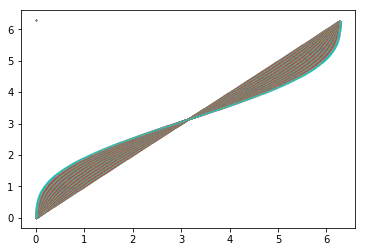

In [11]:
for e_trial in np.arange(0, 1.0, 0.01):
    Es = np.linspace(0, 2*np.pi, 1000)
    Ms = E_to_M(Es, e_trial)
    E1 = M_to_E(Ms, e_trial)
    #print((E1-Es).max())

    plt.scatter(Ms, Es, s=0.1)


In [12]:
def chebynodes(a, b, n):
    k = np.linspace(1, n, n)
    return 0.5*(a+b) + 0.5*(b-a)*np.cos(np.pi*((2*k-1)/(2*n)))

In [13]:
M_to_E_guess(1.5, 0.1)

AttributeError: 'float' object has no attribute 'astype'

In [14]:
chebynodes(0, 2*np.pi, 7)

array([6.20441902, 5.5977887 , 4.50467862, 3.14159265, 1.77850669,
       0.68539661, 0.07876629])

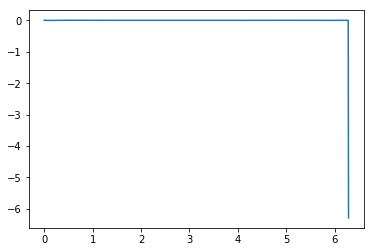

In [15]:
e_trial=0.5
order=11
Ms = chebynodes(0, 2*np.pi, order)
Es = M_to_E(Ms, e_trial)
cs=np.polynomial.chebyshev.chebfit(Ms, Es, order)
ts=np.linspace(0, 2*np.pi, 1000)
E1 = M_to_E(ts, e_trial)
yf = np.polynomial.chebyshev.chebval(ts, cs)

plt.plot(ts, E1-yf)
#plt.scatter(ts, yf, s=0.1)

In [16]:
def random_vec(nsamp=1000000):
    u = np.random.uniform(-1,1, size=nsamp)
    incl = np.arccos(u)
    longnode = np.random.uniform(0,2*np.pi, size=nsamp)
    r = np.zeros((nsamp, 3), dtype=np.float)
    r[:,0] = np.sin(incl)*np.cos(longnode)
    r[:,1] = np.sin(incl)*np.sin(longnode)
    r[:,2] = np.cos(incl)
    return r

In [17]:
def random_ortho(nsamp):
    rvecs = random_vec(nsamp)
    pvecs = np.zeros((nsamp,3))
    pvecs[:,0]=rvecs[:,1]
    pvecs[:,1]=-rvecs[:,0]
    p = np.linalg.norm(pvecs,axis=1)
    pvecs=pvecs/p[:,None]
    cvecs=np.cross(rvecs,pvecs)
    theta = np.random.uniform(0,2*np.pi, size=nsamp)
    fvecs = pvecs*np.cos(theta[:,None]) + cvecs*np.sin(theta[:,None])
    return rvecs, fvecs, np.cross(rvecs, fvecs)


In [18]:
def P9_sample(nsamp=1000000, e_max=0.99):
    r0, pvecs, _ = random_ortho(nsamp)
    x, y, z = r0[:,0], r0[:,1], r0[:,2]
    xn, yn, zn = pvecs[:,0], pvecs[:,1], pvecs[:,2]
 
    e = np.random.uniform(0.,e_max, size=nsamp)
    meananom = np.random.uniform(0,2*np.pi, size=nsamp)
    E = M_to_E(meananom, e, iter=10)
    r = np.random.uniform(100,3000, size=nsamp)    
    a = r/(1.-e*np.cos(E))
    incl = np.arccos(zn)
    longnode = np.arctan2(xn, -yn)
    
    cosnode=np.cos(longnode)
    sinnode=np.sin(longnode)

    rcosu = x*cosnode + y*sinnode
    rsinu =(y*cosnode - x*sinnode)/zn
    u = np.arctan2(rsinu, rcosu)
    trueanom = E_to_f(E, e)
    argperi = (u - trueanom) % (2*np.pi)
    
    pix = hp.vec2pix(32, x, y, z)
    
    return a, e, incl, longnode, argperi, meananom, pix



In [19]:
%%time
a, e, incl, longnode, argperi, meananom, pix = P9_sample(nsamp=1000000, e_max=0.95)

CPU times: user 1.97 s, sys: 237 ms, total: 2.21 s
Wall time: 745 ms


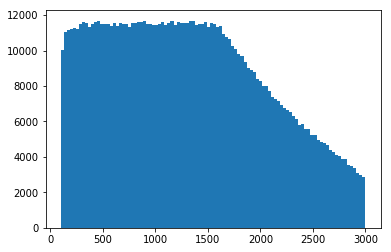

In [20]:
_=plt.hist(a, bins=100, range=(100, 3000))

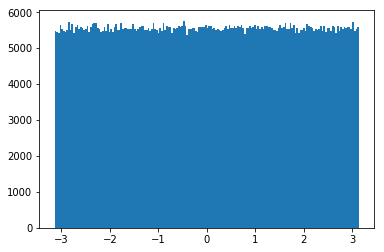

In [21]:
_=plt.hist(longnode, bins=180)

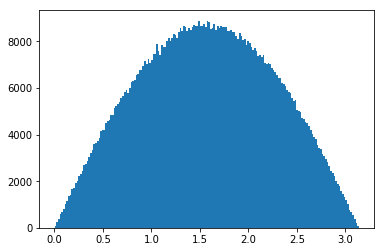

In [22]:
_=plt.hist(incl, bins=180)

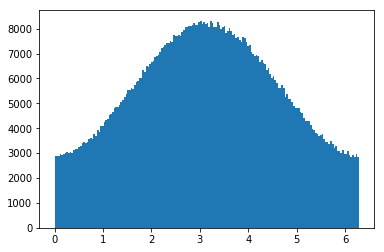

In [23]:
_=plt.hist(M_to_E(meananom, e), bins=180)

In [24]:
E = M_to_E(meananom, e)
M1 = E_to_M(E, e)
f = E_to_f(E, e)
E1 = f_to_E(f, e)

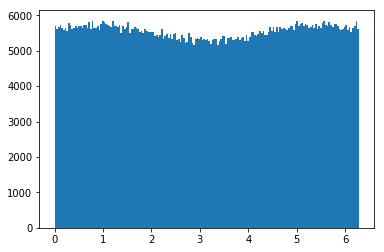

In [25]:
_=plt.hist(f, bins=180)

In [26]:
(meananom-M1).max()

2.7199813659173344e-06

In [27]:
len(pix)

1000000

In [28]:
pix_counter = Counter(pix)

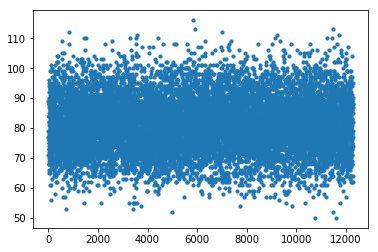

In [29]:
plt.scatter(list(pix_counter.keys()), list(pix_counter.values()), s=10)

In [ ]:
import kepcart as kc

In [ ]:
GMsun = 2.9591220828559115e-04 

In [ ]:
states = kc.cartesians(1000000, GMsun, a, e, incl, longnode, argperi, meananom)

In [ ]:
print(states[0].z)

In [ ]:
with open('P9_states.txt', 'w') as file:
    outstring='# These are initial cartesian ecliptic states for a P9 sample\n'
    outstring+='# Generated using the P9_sample function in the PS1_debias.ipynb notebook\n'
    outstring+='#\n'
    outstring+='# x y z xd yd zd\n'
    outstring+='# units are AU and AU/day\n'
    outstring+='#\n'
    outstring+='# r ~ uniform 100-3000 AU\n'
    outstring+='# e ~ U (0,1)\n'
    outstring+='# M ~ uniform 0-2pi\n'
    outstring+='# e, M --> E\n'
    outstring+='# r, E, e --> a\n'
    outstring+='# i is isotropic\n'
    outstring+='# longnode, argperi are uniform 0-2pi\n'
    outstring+='#\n'
    file.write(outstring)
    for state in states:
        outstring='particle\n%.16f %.16f %.16f %.16e %.16e %.16e\n' % (state.x, state.y, state.z, state.xd, state.yd, state.zd)
        file.write(outstring)

In [ ]:
def chebynodes(a, b, n):
    k=np.linspace(1,n,n)
    return 0.5*(a+b) + 0.5*(b-a)*np.cos(np.pi*(2*k-1)/(2*n))

In [ ]:
P9_dict=defaultdict(list)
with open('P9_files.txt') as file:
    for line in file:
        print(line.rstrip())
        i=0
        for v in open(line.rstrip()):
            if v.startswith('#'):
                t = float(v.split()[1])
            else:
                P9_dict[t].append(tuple(map(float, v.split())))
                i += 1
                
for key in P9_dict.keys():
    P9_dict[key] = np.array(P9_dict[key])



                    
            

In [ ]:
P9_dict[2454466.5].shape

In [90]:
times = np.linspace(2454466.5, 2458466.5, 41)
#times = np.linspace(2454466.5, 2454566.5, 2)
times

array([2454466.5, 2454566.5, 2454666.5, 2454766.5, 2454866.5, 2454966.5,
       2455066.5, 2455166.5, 2455266.5, 2455366.5, 2455466.5, 2455566.5,
       2455666.5, 2455766.5, 2455866.5, 2455966.5, 2456066.5, 2456166.5,
       2456266.5, 2456366.5, 2456466.5, 2456566.5, 2456666.5, 2456766.5,
       2456866.5, 2456966.5, 2457066.5, 2457166.5, 2457266.5, 2457366.5,
       2457466.5, 2457566.5, 2457666.5, 2457766.5, 2457866.5, 2457966.5,
       2458066.5, 2458166.5, 2458266.5, 2458366.5, 2458466.5])

In [ ]:

#plt.scatter(times, ys, s=5)
order=7
samp=9001
xyz=2
ys=[P9_dict[t][samp] for t in times]
cs=np.polynomial.chebyshev.chebfit(times, ys, order)
ts=np.linspace(times[0], times[-1], 10000)
yf = np.polynomial.chebyshev.chebval(times, cs)
(yf.T-ys)[:,xyz]
plt.scatter(times, (ys-yf.T)[:,0], s=10)
plt.ylim(-3e-10, 3e-10)

In [94]:
c = MPC_library.Constants.speed_of_light

In [ ]:
coeffs={}
for samp in range(1000000):
    if samp%10000==0:
        print(samp)
    # Rotate to equatorial and fit for coefficients.  This can be done in advance
    ys=[P9_dict[t][samp] for t in times]
    ys=list(map(lambda x: np.dot(MPC_library.rotate_matrix(MPC_library.Constants.ecl), x[0:3]), ys))
    coeffs[samp]=np.polynomial.chebyshev.chebfit(times, ys, order)

In [ ]:
coeffs[990002]

In [86]:
import pickle

In [ ]:
with open('coeffs.pkl', 'wb') as file:
    pickle.dump(coeffs, file)

In [87]:
with open('coeffs.pkl', 'rb') as file:
    coeffs = pickle.load(file)

In [88]:
len(coeffs)

1000000

In [91]:
ts=np.linspace(times[0], times[-1], 4000)
re_dict = {}
tdb_dict = {}
for t in ts:
    # convert time UTC to time TDB
    tdb_dict[t] = MPC_library.EOP.jdTDB(t)

    # get observatory position
    re_dict[t] = MPC_library.Observatories.getObservatoryPosition('F51', t)

In [92]:
times[-1]-times[0]

4000.0

In [95]:

ras=[]
decs=[]

for samp in range(1000):
    
    print(samp)

    # Rotate to equatorial and fit for coefficients.  This can be done in advance
    #ys=[P9_dict[t][samp] for t in times]
    #ys=list(map(lambda x: np.dot(MPC_library.rotate_matrix(MPC_library.Constants.ecl), x[0:3]), ys))
    #cs=np.polynomial.chebyshev.chebfit(times, ys, order)
    cs=coeffs[samp]

    for t in ts:
        # convert time UTC to time TDB
        t_tdb=tdb_dict[t]

        # get observatory position
        re=re_dict[t]

        dt = 0.0
        for i in range(3):
            tp = t_tdb - dt

            # evaluate position at t'
            r = np.polynomial.chebyshev.chebval(tp, cs)[0:3]

            d = np.linalg.norm(r - re)
            dt = d/c
        
        x, y, z = (r-re)/d
        ra = (np.arctan2(y, x)*180./np.pi ) % 360.
        dec = np.arcsin(z)*180./np.pi
        #print("%7d %9.1f %9.5f %11.6f %10.6f" % (samp, t, dt, ra, dec))#, (r-re)/d)
        ras.append(ra)
        decs.append(dec)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
times

In [ ]:
hp_dict=defaultdict(list)

t = ts[0]
t_tdb=tdb_dict[t]
    
# get observatory position
re=re_dict[t]

for samp in range(1000000):
    
    if samp % 100000 == 0:
        print(samp)

    cs=coeffs[samp]

    dt = 0.0
    for i in range(3):
        tp = t_tdb - dt

        # evaluate position at t'
        r = np.polynomial.chebyshev.chebval(tp, cs)[0:3]

        d = np.linalg.norm(r - re)
        dt = d/c
        
    x, y, z = (r-re)/d
    ra = (np.arctan2(y, x)*180./np.pi ) % 360.
    dec = np.arcsin(z)*180./np.pi
    pix = ps1_utils.ra_dec2pix(ra, dec, nested=False)
    hp_dict[pix].append(samp)


In [ ]:
lens = np.array([len(hp_dict[i]) for i in sorted(hp_dict.keys())])

In [ ]:
1e6/hp.nside2npix(32)

In [ ]:
plt.scatter(range(len(lens)), lens, s=1)

In [ ]:
lens.mean(), lens.std()

In [ ]:
def mag(r, d, H):
    m = H + 5.0*np.log10(r*d)
    return m

def H(r, d, m):
    H = m - 5.0*np.log10(r*d)
    return H

rs = np.arange(100,3000,1)


In [ ]:
plt.plot(rs, H(rs, rs-1.0, 24))
#plt.plot(ds, H(rs, rs-1.0, 21))
plt.plot(rs, H(rs, rs-1.0, 22.5))
plt.plot(rs, H(rs, rs-1.0, 13))
plt.xscale("log", nonposx='clip')
#plt.yscale("log", nonposy='clip')
r=np.random.uniform(100,3000, size=10000)
m=np.random.uniform(13,24, size=10000)
Hs=H(r,r-1,m)
plt.scatter(r, Hs, s=2)
plt.ylim(-8, 4)
plt.xlabel('r (AU)')
plt.ylabel('H mag')

In [ ]:
plt.scatter(ras, decs, s=0.001, marker=',')
plt.xlim(205,215)
plt.ylim(0,-10)
plt.savefig('radec.pdf')

In [1]:
from scipy.integrate import solve_ivp
def exponential_decay(t, y): return -0.5 * y
    
sol = solve_ivp(exponential_decay, [0, 10], [2, 4, 8])
print(sol.t)
print(sol.y)


[ 0.          0.11487653  1.26364188  3.06061781  4.85759374  6.65456967
  8.4515456  10.        ]
[[2.         1.88836035 1.06327177 0.43319312 0.17648948 0.0719045
  0.02929499 0.01350938]
 [4.         3.7767207  2.12654355 0.86638624 0.35297895 0.143809
  0.05858998 0.02701876]
 [8.         7.5534414  4.25308709 1.73277247 0.7059579  0.287618
  0.11717996 0.05403753]]


In [6]:
sol.success

True

In [7]:
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body, get_moon
t = Time("2014-09-22 23:22")
loc = EarthLocation.of_site('greenwich') 
with solar_system_ephemeris.set('builtin'):
    jup = get_body('jupiter', t, loc) 


In [10]:
from astropy import coordinates

In [11]:
coordinates.get_body_barycentric_posvel

<function astropy.coordinates.solar_system.get_body_barycentric_posvel>

In [20]:
jup

<SkyCoord (GCRS: obstime=2014-09-22 23:22:00.000, obsgeoloc=(3949481.6923192, -550931.9066837, 4961151.73597582) m, obsgeovel=(40.15951031, 287.47876669, -0.04597867) m / s): (ra, dec, distance) in (deg, deg, AU)
    (136.91116209, 17.02935409, 5.94386022)>

In [22]:
solar_system_ephemeris.set('de432s') 
get_body('jupiter', t, loc) 
get_moon(t, loc) 
jup=coordinates.get_body_barycentric('jupiter', t) 


In [34]:
np.array(jup.to_cartesian)+1

TypeError: unsupported operand type(s) for +: 'method' and 'int'

In [37]:
np.array((1, 1, 1)) + 1

array([2, 2, 2])

In [38]:
import jplephem

In [39]:
position = kernel[0,4].compute(2457061.5)


NameError: name 'kernel' is not defined

In [40]:
from jplephem.spk import SPK

In [41]:
kernel = SPK.open('de430.bsp')

In [42]:
print(kernel)

File type DAF/SPK and format LTL-IEEE with 14 segments:
2287184.50..2688976.50  Solar System Barycenter (0) -> Mercury Barycenter (1)
2287184.50..2688976.50  Solar System Barycenter (0) -> Venus Barycenter (2)
2287184.50..2688976.50  Solar System Barycenter (0) -> Earth Barycenter (3)
2287184.50..2688976.50  Solar System Barycenter (0) -> Mars Barycenter (4)
2287184.50..2688976.50  Solar System Barycenter (0) -> Jupiter Barycenter (5)
2287184.50..2688976.50  Solar System Barycenter (0) -> Saturn Barycenter (6)
2287184.50..2688976.50  Solar System Barycenter (0) -> Uranus Barycenter (7)
2287184.50..2688976.50  Solar System Barycenter (0) -> Neptune Barycenter (8)
2287184.50..2688976.50  Solar System Barycenter (0) -> Pluto Barycenter (9)
2287184.50..2688976.50  Solar System Barycenter (0) -> Sun (10)
2287184.50..2688976.50  Earth Barycenter (3) -> Moon (301)
2287184.50..2688976.50  Earth Barycenter (3) -> Earth (399)
2287184.50..2688976.50  Mercury Barycenter (1) -> Mercury (199)
228718

In [43]:
position = kernel[0,4].compute(2457061.5)

In [58]:
epoch, length, arr=kernel[0,10].load_array()

In [64]:
arr[0][0]

array([-6.43787852e+05,  6.48526575e+03,  1.48447580e+01, -1.36403333e-01,
        3.58349840e-03, -9.48783920e-04,  7.70137805e-05,  2.74925283e-06,
       -1.74234040e-06,  2.61347105e-07, -1.52290910e-08])

In [44]:
print(position)

[2.05700211e+08 4.25141646e+07 1.39379183e+07]


In [45]:
type(position)

numpy.ndarray

In [46]:
kernel

In [ ]:
Radec = {}
with open('horizons_results.txt') as file:
    for line in file:
        Radec[float(line[:17])] = (float(line[22:31]), float(line[32:41]))
times = list(Radec.keys())


def getHimaliaRadec(time):
    i = 0
    while i < len(times) and times[i] < time:
        i+=1
    x1 = times[i]
    x0 = times[i-1]
    y0 = Radec[times[i-1]]
    y1 = Radec[times[i]]
    print(y1, y0)
    frac = (time-x0)/(x1-x0)
    comboRA = frac*(y0[0]) + (1-frac)*(y1[0])
    comboDEC = frac*(y0[1]) + (1-frac)*(y1[1])
    return (comboRA, comboDEC)

getHimaliaRadec(2455566.7315502)